#Code to solve the Travel Salesman Problem (TSP) using first the PULP module in python that uses the CBC solver giving optimality. The TSP model that will be used is the Miller-Tucker-Zemlin (MTZ) formulation, which is a common way of preventing subtours in the TSP. Then I will trying the simulation annealing algorithm with different paramters that help me to have a better look in quality of the solution and in running time improvement.

Installing Pulp in this notebook.

In [ ]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 29.9 MB/s eta 0:00:00


Testing if pulp installed correctly:

In [ ]:
import pulp
#from google.colab import drive
#drive.mount('/content/gdrive')
import numpy as np
import random
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus
import time #for timing the solutions
#pulp.pulpTestAll()

Reusabe version (OOP) of the TSP problem using the pulp library and Simulation annealing:

In [ ]:
class TSPSolver:

  def __init__(self, a_number_of_cities, a_matrix_of_distances,a_edges):
    self.number_of_cities = a_number_of_cities
    self.matrix_of_distances = a_matrix_of_distances
    self.Cities = list(range(self.number_of_cities))
    self.edges=a_edges



class Optimal_CBC(TSPSolver):

  def solver_method(self):

    # create the problem
    prob = LpProblem("TSP", LpMinimize)

    # decision variables
    x = LpVariable.dicts('x', ((i, j) for i in self.Cities for j in self.Cities), cat='Binary')
    #x=[LpVariable(name=f'x_{i}{j}',]
    u = LpVariable.dicts('u', (i for i in self.Cities), lowBound=0, upBound=(self.number_of_cities-1), cat='Continuous') #Making the variables

    #print(x)

    #objective function
    prob += lpSum(self.matrix_of_distances[i][j] * x[i, j] for i in self.Cities for j in self.Cities if i != j)

    # constraints
    for i in self.Cities:
        prob += lpSum(x[i, j] for j in self.Cities if i != j) == 1  # leave each city once

    for j in self.Cities:
        prob += lpSum(x[i, j] for i in self.Cities if i != j) == 1  # enter each city once

    for i in self.Cities:
      for j in self.Cities:
        if i != j and (i != 0 and j!= 0):
            prob += u[i] - u[j] <= (self.number_of_cities)*(1-x[i, j]) - 1  # subtour elimination

    # solve the problem
    status = prob.solve(pulp.PULP_CBC_CMD(options=["sec=360"])) # after 6 minutes stop

    # print the values of the matrix of x[i,j]
    print(LpStatus[status])
    for i in self.Cities:
        for j in self.Cities:
            if x[i, j].varValue:
                print(f"x[{i},{j}] = {x[i, j].varValue}")
    #print(self.edges[0])
    solution_edges=[edge for edge in self.edges if x[edge].varValue > 0.95]
    #print(prob)
    z=pulp.value(prob.objective)
    #print(pulp.value(x))

    return x,solution_edges,z

class Heurist_SimAnn(TSPSolver):

  def __init__(self,a_number_of_cities, a_matrix_of_distances,a_edges,a_coordinates,a_max_iterations_out,a_max_iterations_in,a_factor2=.99):
    super().__init__(a_number_of_cities, a_matrix_of_distances,a_edges)
    self.coordinates=a_coordinates
    self.max_iter_in=a_max_iterations_in
    self.factor2=a_factor2 #guesstimation to check
    self.max_iter_out=a_max_iterations_out

  def solver_method(self):

    #Simulated annealing algorithm

    # Initial Distance

    #objective=Cities.get_total_distance(self.matrix_of_distances,self.coordinates)
    objective=Cities.get_total_distance_2(self.coordinates)
    #print('obj is: ',objective)

    #INITIAL TEMPERATURE GETTING FROM HILLER T_initial>|Zn-Zc|
    T_ini=30
    T=T_ini
    #print('T is: ',T)
    coords=self.coordinates.copy()
    #print('initial sln: ',coords)

    #time to control the loop
    start_time = time.time()

    for _ in range(self.max_iter_out):
      T=T*self.factor2
      #breaking the outer loop after 360 seconds
      if time.time() - start_time >= 360:
        print("360 seconds have passed. Breaking the loop.")
        break


      for _ in range(self.max_iter_in):# max iterations is the same.
        #random generator of neighbor solutions
        r1,r2=np.random.randint(0,self.number_of_cities,size=2)
        temp=coords[r1].copy()
        coords[r1]=coords[r2]
        coords[r2]=temp
        # new distance of the candidate solution:
        #mat_dist=Cities.compute_dis(coords,self.number_of_cities)

        #candidate=Cities.get_total_distance(mat_dist,coords)
        candidate=Cities.get_total_distance_2(coords)


        #check the performance new solution
        if candidate<objective:# choose new solution if better

          objective=candidate

        else:

          p=np.random.uniform()

          if p< np.exp((objective-candidate)/T): #choose worse sln with probability

            objective=candidate

          else: # Do not choose new solution
            temp=coords[r1].copy()
            coords[r1]=coords[r2]
            coords[r2]=temp






    return objective,coords


Class alternative of the one above, getting matrix of distance for the CBC, and getting the computation of the total cost(distance):

In [ ]:


class Cities:
    def __init__(self, a_num_cities,a_grid_size=50):
        self.num_cities = a_num_cities
        self.grid_size= a_grid_size
        self.cities = self.create_cities()

    ##########################################New Problem################################
    @staticmethod
    def dist_mat_SAI(coordinates):


      num_cities = len(coordinates)
    #distance_matrix = np.zeros((num_cities, num_cities))
      distance_matrix={}

      for i in range(num_cities):
          for j in range(i+1, num_cities):
                #print(f'values: ({i},{j})')
                x1, y1 = coordinates[i][0]
                x2, y2 = coordinates[j][0]
                distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                #distance_matrix[coordinates[i][1],coordinates[j][1]]= distance # def
                #distance_matrix[coordinates[j][1],coordinates[i][1]]= distance # def
                #distance_matrix[i,j] = distance
                #distance_matrix[j,i] = distance # Matrix is symmetric
                distance_matrix[(i,j)] = distance # easier
                distance_matrix[(j,i)] = distance
                #print(distance_matrix)
                #print()
      return distance_matrix

    @staticmethod
    def cos_SAI(coordinates):


      num_cities = len(coordinates)
      cosines = {}
    #cosines_m = np.zeros((num_cities, num_cities,num_cities))

      for i in range(num_cities):
        for j in range(num_cities):
            for k in range(num_cities):
                if i != j and i != k and j != k:
                    # Vector from i to j
                    vec_ji = np.array(coordinates[i][0]) - np.array(coordinates[j][0])
                    # Vector from i to k
                    vec_jk = np.array(coordinates[k][0]) - np.array(coordinates[j][0])

                    # Compute the angle using dot product
                    cos_theta = np.dot(vec_ji, vec_jk) / (np.linalg.norm(vec_ji) * np.linalg.norm(vec_jk)) # all vectors going out from the mid vertex
                    #theta = np.pi-np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clipping is used to handle numerical errors, No need of this if the cosine is closer to -1 that is what we want

                    #cosines.append((i, j, k, cos_theta))
                    cosines[(i,j,k)]=cos_theta

      return cosines

    @staticmethod
    def portion_list(list, num_portions):

      if num_portions <= 0:
        raise ValueError("Number of portions must be greater than 0.")

      if len(list) % num_portions != 0:
        raise ValueError(
        "The length of the list must be a multiple of the number of portions.")

      sublist_size = len(list) // num_portions
      sublists = []
      for i in range(num_portions):
        sublists.append(list[ (i * sublist_size) : ((i + 1) * sublist_size)])

      return sublists

    @staticmethod
    def compute_total_distance_and_sum_of_cosines(city_distances, city_cosines, cities):


      cum_distance = 0
      cum_of_cosines = 0
      N=len(cities)
      for i in range(N-1):
    #print(f'the number {i} city is {cities[i][1]} and neighbor {i+1} is {cities[i+1][1]} ')
        cum_distance += city_distances[(cities[i][1],cities[i+1][1])]
    #print(f'the cummulative distance so far is {cum_distance}')
      for i in range(N-2):
    #print(f'the number {i} city is {cities[i][1]} and 1st neighbor {i+1} is {cities[i+1][1]} and the 2nd neighbor {i+2} is {cities[i+2][1]} ')
        cum_of_cosines += city_cosines[(cities[i][1],cities[i+1][1],cities[i+2][1])]
    #print(f'the cummulative cosines so far is {cum_of_cosines}')

      return cum_distance, cum_of_cosines

    @staticmethod
    def objective_comp(coordinates,num_travels,distances,cosines,alpha): # or number of vendors, vehicules, journeys you would need to cover all the sites
      list_of_lists=Cities.portion_list(coordinates,num_travels)
      objective=0
      for l in list_of_lists:
        dist,cos=Cities.compute_total_distance_and_sum_of_cosines(distances,cosines,l)
        objective +=dist
        objective +=(alpha)*cos
      return objective
    @staticmethod
    def gen_coords_SAI(num_cities, seed=None):

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        coordinates = [((random.uniform(0.1, 1), random.uniform(0.1,1)),i) for i in range(num_cities)]
    #coordinates.append(('CO'))
        return coordinates


    #############################################TSP################
    def create_cities(self):
        return np.array([self.create_random_coordinates() for _ in range(self.num_cities)])

    def create_random_coordinates(self):
        x = np.random.uniform(0, self.grid_size)
        y = np.random.uniform(0, self.grid_size)
        return np.array((x, y))

    def get_cities(self):
        return self.cities

    def get_edges(self):
        return [(i,j) for i in range(self.num_cities) for j in range(self.num_cities) if i!=j] #np.array([(i,j) for i in range(self.num_cities) for j in range(self.num_cities) if i!=j] )



    @staticmethod # it can be called without an instance of a Cities object
    def compute_dis(a_cities,a_num_cities):
      return np.array([[np.linalg.norm(a_cities[i]-a_cities[j]) for j in range(a_num_cities)] for i in range(a_num_cities)])

    @staticmethod # it can be called without an instance of a Cities object
    def get_total_distance(a_distances,a_cities):
      total_distance=0
      for i in range(len(a_cities)-1):
        total_distance+=a_distances[i,i+1]
      total_distance+=a_distances[i+1,0]
      return total_distance

    @staticmethod
    def get_distance(a_point,b_point):
      return np.linalg.norm(a_point-b_point)

    @staticmethod
    def get_total_distance_2(a_cities):
      total_distance=0
      for i in range(len(a_cities)-1):
        total_distance+=Cities.get_distance(a_cities[i],a_cities[i+1])
      total_distance+=Cities.get_distance(a_cities[0],a_cities[-1])
      return total_distance


## This formula will let me compute the objective function faster and easier














Getting random data for the problem:

In [ ]:

np.random.seed(4)
n = 9
cities = Cities(n)
coords=cities.get_cities()
matrix_dist=Cities.compute_dis(coords,n)
edges=cities.get_edges()
seq_total_dist=Cities.get_total_distance(matrix_dist,coords)
seq_total_dist_2=Cities.get_total_distance_2(coords)
#print(coords)  # print the coordinates of the cities
#print(cities.compute_distances())  # print the distances between each pair of cities
print()
#print(matrix_dist)
print()
#print('Total distance:',cities.get_total_distance(matrix_dist,coords))
print('Total distance 1:',seq_total_dist)
print()
print('Total distance 2:',seq_total_dist_2)
print()
print('number of edges are:',len(edges))
print()
#print('edges: ',edges)
print('cities: ',coords)



Total distance 1: 266.2880596884313

Total distance 2: 266.2880596884313

number of edges are: 72

cities:  [[48.35149195 27.36161246]
 [48.634218   35.74079968]
 [34.88644123 10.80447478]
 [48.81372274  0.31151276]
 [12.64911812 21.73957662]
 [38.96914609  9.88425373]
 [43.14966178 49.17003386]
 [ 8.19211207 29.8666972 ]
 [ 0.44930488 19.32856413]]


Testing the solutions Pulp (Optimal):

In [ ]:
# number of cities (6)(25)(3)


TSP_opt=Optimal_CBC(a_number_of_cities=n,a_matrix_of_distances=matrix_dist,a_edges=edges)

Solution=TSP_opt.solver_method()


Optimal
x[0,3] = 1.0
x[1,0] = 1.0
x[2,4] = 1.0
x[3,5] = 1.0
x[4,8] = 1.0
x[5,2] = 1.0
x[6,1] = 1.0
x[7,6] = 1.0
x[8,7] = 1.0


In [ ]:
#Solution

Testing Heuristic:


In [ ]:
#print(coords)
#max_iter_in=50

TSP_opt_2=Heurist_SimAnn(a_number_of_cities=n,a_matrix_of_distances=matrix_dist,a_edges=edges,a_coordinates=coords,a_max_iterations_in=500,a_max_iterations_out=1000,a_factor2=0.99) #a_max_iterations=10,a_factor1=0.2,a_factor2=0.994,a_max_iterations=20,a_factor1=0.2,a_factor2=0.993

Solution1=TSP_opt_2.solver_method()

In [ ]:
heuristic=Solution1[1]
Solution1[0]
#heuristic

158.08680546586902

Visualisation, but must be generalised making it a class:

In [ ]:
class Plots_TSP:

  def __init__(self,a_coords_seq,a_arcs_opt,a_coords_heu,a_z_opt,a_z_heu,a_seq_total_distance):
    self.coords_seq=a_coords_seq
    self.arcs_opt=a_arcs_opt
    self.coords_heu=a_coords_heu
    self.z_opt=a_z_opt
    self.z_heu=a_z_heu
    self.seq_total_distance=a_seq_total_distance

  def plot_sln(self):
    fig=plt.figure(figsize=(15,5))
    ax1=fig.add_subplot(131)
    ax2=fig.add_subplot(132)
    ax3=fig.add_subplot(133)

    #Sequential
    for first,second in zip(self.coords_seq[:-1],self.coords_seq[1:]):
          ax1.plot([first[0],second[0]],[first[1],second[1]],'b')
    ax1.plot([self.coords_seq[0][0],self.coords_seq[-1][0]],[self.coords_seq[0][1],self.coords_seq[-1][1]],'b') # this one connects the first with the last point to make a close loop

    #Coordinates in all subplots

    for c in self.coords_seq:
      ax1.plot(c[0],c[1],'ro')
      ax2.plot(c[0],c[1],'ro')
      ax3.plot(c[0],c[1],'ro')

    #Optimal
    for i,j in self.arcs_opt:
      ax2.plot([self.coords_seq[i][0],self.coords_seq[j][0]],[self.coords_seq[i][1],self.coords_seq[j][1]],'b')

    #Heuristic
    for first,second in zip(self.coords_heu[:-1],self.coords_heu[1:]):
          ax3.plot([first[0],second[0]],[first[1],second[1]],'b')
    ax3.plot([self.coords_heu[0][0],self.coords_heu[-1][0]],[self.coords_heu[0][1],self.coords_heu[-1][1]],'b') # this one connects the first with the last point to make a close loop

    # Titles
    ax1.set_title(f"Sequential Distance, Distance {self.seq_total_distance:.3f}")
    ax2.set_title(f"Optimal CBC Distance {self.z_opt:.3f}")
    ax3.set_title(f"Heuristic SA Distance {self.z_heu:.3f}")


    plt.show()






In [ ]:
#n=0
#while(n<1000):
 # n=n+1
  #print(n)
  #i=0
 # while(i<500):
   # i=i+1
    #print(i)

#print(n)
#print(i)

1000
500


In [ ]:
9# checking for solution integrity that is not in the TSP-solver SA  compute_dis(a_cities,a_num_cities): and  get_total_distance(a_distances,a_cities) for checking for heuristic
mat=Cities.compute_dis(heuristic,n)
tot_dist_heur=Cities.get_total_distance(mat,heuristic)
print('the total distance of the heuristic is: ',tot_dist_heur)
print()
#print(heuristic)


the total distance of the heuristic is:  158.08680546586902



This is for tunning the initial temperature for SA

In [ ]:
print(.10*1118)

print(np.exp((1118-1300)/(.10*1118))) #72.5,60,40

111.80000000000001
0.19634008874051195


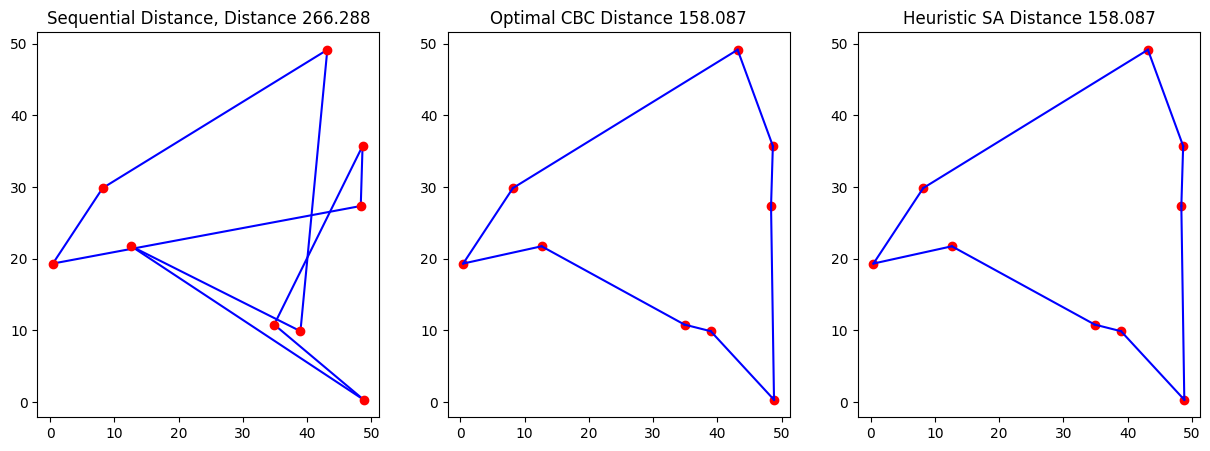

In [ ]:
Plt=Plots_TSP(coords,Solution[1],heuristic,Solution[2],Solution1[0],seq_total_dist)

Plt.plot_sln()

##Now We have a different problem:  the problem is that I have n points (x,y) to visit only once, let say n=20, but I do not have to visit all of them forming a loop like the TSP, instead I have to visit them in group of m cities, let  say m=4, and my objective function should minimise the distance between the cities visited, and supposing the distance between two cities is a straight line,  I should also minimised the angle that is formed by the edges for three consecutives cities.  
#Parameters of interest:
$d_{ij}$: Distance between city $i$ and city $j$.

$\alpha_{ijk}$: Angle formed by cities $i$, $j$, and $k$ when visited consecutively.




##But First let's Change the SA implementation of this problem given is easier:
###We will be computing the matrix $A$ of all the angles for triplets, then Modified the objective function, Then Modify the plotting function for this problem.




In [ ]:
#always gives you a value between 0 and pi
def angle_between(a,b):
  return np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))

a=np.array([-1,0])
b=np.array([1,0])

print(angle_between(a,b))

3.141592653589793


In [ ]:
import itertools
import numpy as np

# Sample set of cities (replace with your actual data)
cities = {
    'A': (1, 2),
    'B': (3, 4),
    'C': (4, 3),
    'D': (2, 1),
    'E': (3,8),
    'F': (0,0)
}

def angle(A, B, C):
    # Vectors BA and BC
    BA = np.array(A) - np.array(B)
    BC = np.array(C) - np.array(B)

    # Normalize the vectors
    BA_normalized = BA / np.linalg.norm(BA)
    BC_normalized = BC / np.linalg.norm(BC)

    # Compute the dot product
    dot_product = np.dot(BA_normalized, BC_normalized)

    # Clamp the value between -1 and 1 to handle numerical errors
    dot_product = np.clip(dot_product, -1.0, 1.0)

    # Compute the angle
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

def compute_angles(cities):
    angles = {}

    # Iterate over all combinations of 3 cities
    for comb in itertools.combinations(cities.keys(), 3):
        A, B, C = comb
        angles[comb] = angle(cities[A], cities[B], cities[C])

    return angles

angles = compute_angles(cities)
for k, v in angles.items():
    print(f"Angle between {k}: {v:.2f} degrees")

Angle between ('A', 'B', 'C'): 90.00 degrees
Angle between ('A', 'B', 'D'): 26.57 degrees
Angle between ('A', 'B', 'E'): 135.00 degrees
Angle between ('A', 'B', 'F'): 8.13 degrees
Angle between ('A', 'C', 'D'): 26.57 degrees
Angle between ('A', 'C', 'E'): 97.13 degrees
Angle between ('A', 'C', 'F'): 18.43 degrees
Angle between ('A', 'D', 'E'): 53.13 degrees
Angle between ('A', 'D', 'F'): 71.57 degrees
Angle between ('A', 'E', 'F'): 2.12 degrees
Angle between ('B', 'C', 'D'): 90.00 degrees
Angle between ('B', 'C', 'E'): 33.69 degrees
Angle between ('B', 'C', 'F'): 81.87 degrees
Angle between ('B', 'D', 'E'): 10.30 degrees
Angle between ('B', 'D', 'F'): 135.00 degrees
Angle between ('B', 'E', 'F'): 20.56 degrees
Angle between ('C', 'D', 'E'): 36.87 degrees
Angle between ('C', 'D', 'F'): 161.57 degrees
Angle between ('C', 'E', 'F'): 31.87 degrees
Angle between ('D', 'E', 'F'): 12.43 degrees


{0: (0.4370861069626263, 0.9556428757689246), 1: (0.7587945476302645, 0.6387926357773329), 2: (0.24041677639819287, 0.2403950683025824), 3: (0.15227525095137953, 0.8795585311974417), 4: (0.6410035105688879, 0.737265320016441), 5: (0.1185260448662222, 0.9729188669457949), 6: (0.8491983767203796, 0.29110519961044856), 7: (0.26364247048639056, 0.2650640588680905), 8: (0.373818018663584, 0.5722807884690141), 9: (0.48875051677790415, 0.36210622617823773), 10: (0.6506676052501416, 0.22554447458683766), 11: (0.3629301836816964, 0.4297256589643226)}
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]


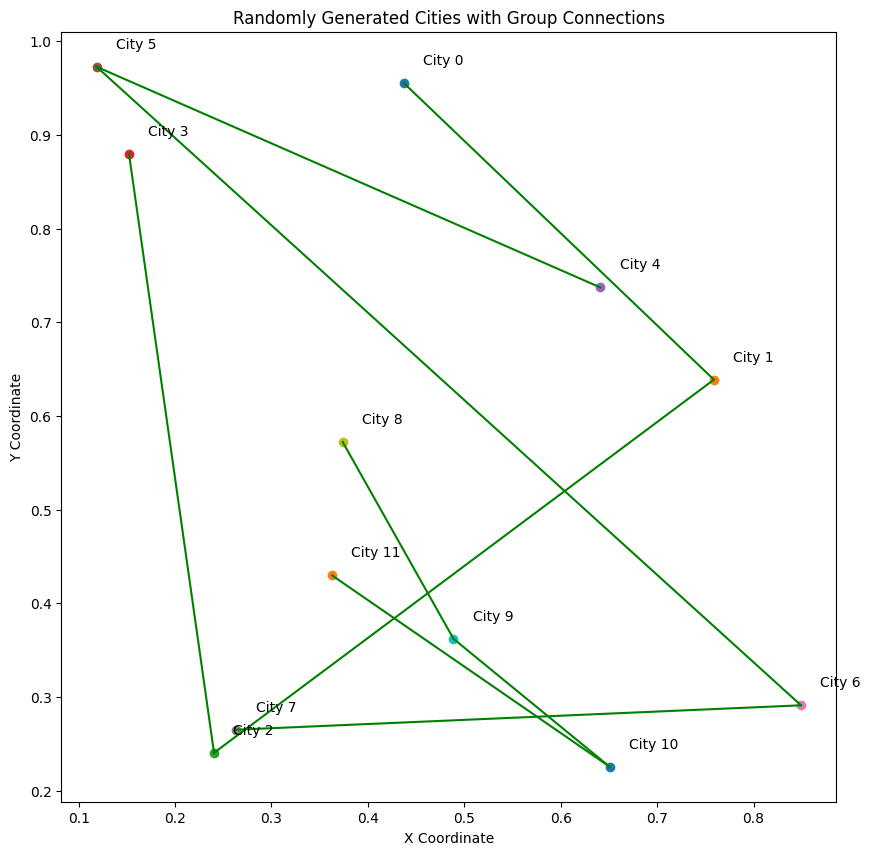

In [ ]:
#This is how I should be presenting the solutions for the new problem n vehicles/vendedores N cities and s/m capacity
import random
import numpy as np
import matplotlib.pyplot as plt

# Number of cities
N = 12
random.seed(42)
random.seed(42)
np.random.seed(42)
# Randomly generate city coordinates
cities = {i: (np.random.uniform(0.1, 1), np.random.uniform(0.1, 1)) for i in range(N)}

print(cities)

# Form 3 groups of 4 cities each
number_of_cities=4
groups = [list(cities.keys())[i:i+4] for i in range(0, N, number_of_cities)]

print(groups)

colors = ['green']
plt.figure(figsize=(10, 10))
# Plot the cities
for i, coords in cities.items():
    plt.scatter(*coords)
    plt.annotate(f'City {i}', (coords[0]+0.02, coords[1]+0.02))

# Connect cities in the same group
for group in groups:
    for i in range(3):  # Connect each city to the next city in the group
        plt.plot([cities[group[i]][0], cities[group[i+1]][0]],
                 [cities[group[i]][1], cities[group[i+1]][1]], color='green')

plt.title('Randomly Generated Cities with Group Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

city_coords=cities.copy()

In [ ]:
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Compute the angle formed by three points
def angle(p1, p2, p3):
    a = np.array(p1) - np.array(p2)
    b = np.array(p3) - np.array(p2)

    cos_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.arccos(np.clip(cos_angle, -1, 1))

    return np.degrees(angle)

# Validation of constraints
total_distance = 0
all_angles = []

# For each group, compute the distances and angles
for group in groups:
    for i in range(3):
        total_distance += distance(cities[group[i]], cities[group[i+1]])
        if i < 2:  # Angle requires three points
            all_angles.append(angle(cities[group[i]], cities[group[i+1]], cities[group[i+2]]))

print(f"Total distance: {total_distance}")
print(f"All angles (degrees): {all_angles}")

# Check if any angle is greater than a certain threshold (optional)
# Let's say, for demonstration purposes, that an angle greater than 170 degrees isn't desirable.
angle_threshold = 170
for ang in all_angles:
    if ang > angle_threshold:
        print(f"Angle {ang} exceeds the threshold!")



Total distance: 456.15123347194344
All angles (degrees): [25.741321317953, 105.48284883465931, 37.8749836510982, 115.20112364547508, 53.53193641689389, 16.202115910053575]


Ahora quiero hacer un modelo matematico en forma de programacion entera mixta del siguiente problema: tengo un conjunto de ciudades que se deben visitar una vez y solo una vez, digamos que son 12 ciudades, para hacer esto cuento en vez de tener un vendedor como el TSP, tengo tres vendedores para hacer esto, cada vendedor debe visitar 4 ciudades de las 12 que hay en total, un vendedor en particular no pueden visitar una ciudad dos veces dentro de las 4 ciudades que tiene para visitar y ademas una ciudad no puede ser visitada por dos vendedores, la decision que se tiene que tomar es que secuencia de 4 ciudades cada vendedor tiene que visitar que minimice la distancia total recorrida por cada vendedor.

$Min z = \sum_{k = 1}^V \sum_{i, j = 1}^C d_{ij} x_{ij}^k$

Solución óptima encontrada!


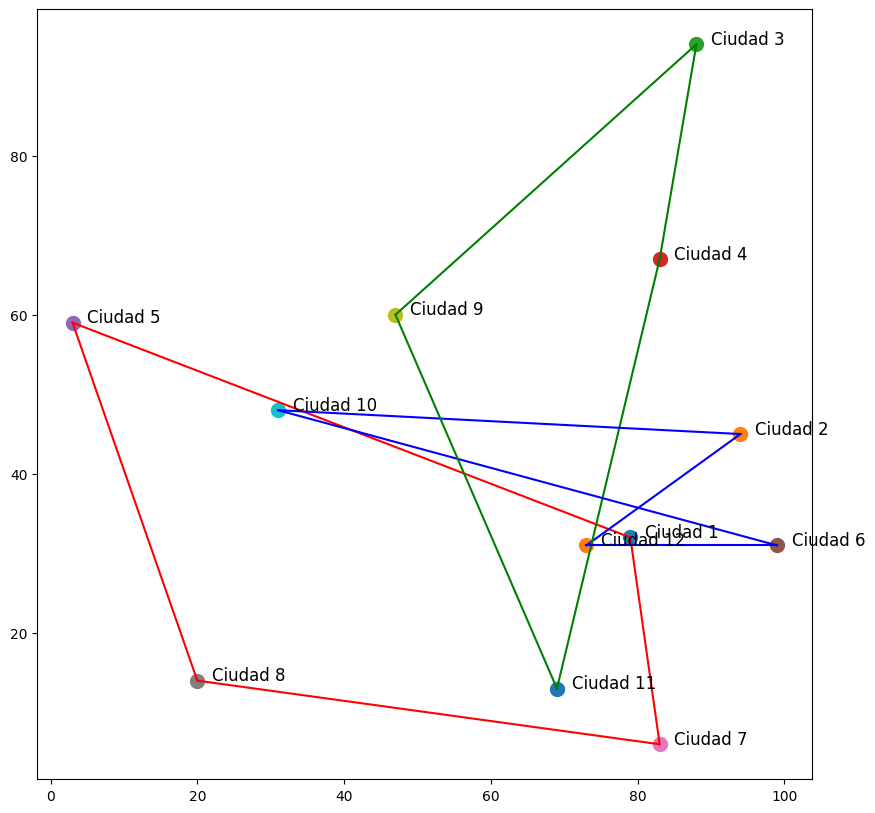

In [ ]:
# Datos iniciales, este si funciona, pero hace 3 subtours
num_ciudades = 12
num_vendedores = 3
capacidad=4
ciudades = range(1, num_ciudades+1)
vendedores = range(1, num_vendedores+1)

# Ejemplo de distancias aleatorias (esto se puede reemplazar con tus distancias reales)
import random
random.seed(5)
distancias = {(i, j): random.randint(1, 100) for i in ciudades for j in ciudades if i != j}

# Modelo
modelo = pulp.LpProblem("TSP_variant", pulp.LpMinimize)

# Variables de decisión
x = pulp.LpVariable.dicts("x", (ciudades, ciudades, vendedores), cat='Binary')
u = pulp.LpVariable.dicts("u", (ciudades, vendedores), 1, capacidad, cat='Continuous')

# Función objetivo
modelo += pulp.lpSum(distancias[i, j] * x[i][j][k] for i in ciudades for j in ciudades if i != j for k in vendedores)

# Restricciones


for i in ciudades:
    modelo += pulp.lpSum(x[i][j][k] for j in ciudades if i != j for k in vendedores) == 1

for k in vendedores:
    modelo += pulp.lpSum(x[i][j][k] for i in ciudades for j in ciudades if i != j) == capacidad

#for i in ciudades:
 #   for j in ciudades:
  #      if i != j:
   #         for k in vendedores:
    #            modelo += u[i][k] - u[j][k] + num_ciudades * x[i][j][k] <= num_ciudades - 1
for i in ciudades:
    for k in vendedores:
        modelo += pulp.lpSum(x[i][j][k] for j in ciudades if i != j) == pulp.lpSum(x[j][i][k] for j in ciudades if i != j)

# Resuelve el modelo
modelo.solve(pulp.PULP_CBC_CMD(msg=True))

# Verifica si la solución es óptima
if modelo.status == pulp.LpStatusOptimal:
    print("Solución óptima encontrada!")
else:
    print("No se encontró una solución óptima!")

# Visualización
random.seed(5)
coords = {i: (random.randint(0, 100), random.randint(0, 100)) for i in ciudades}  # Coordenadas aleatorias, puedes reemplazarlo con tus datos
colors = ['r', 'g', 'b']

plt.figure(figsize=(10, 10))

for i in ciudades:
    for j in ciudades:
        if i != j:
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:
                    plt.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color=colors[k-1])

for i in ciudades:
    plt.scatter(coords[i][0], coords[i][1], s=100)
    if i == 0:
        plt.text(coords[i][0]+2, coords[i][1], 'CO', fontsize=12)
    else:
        plt.text(coords[i][0]+2, coords[i][1], f'Ciudad {i}', fontsize=12)

plt.show()

##Conjuntos:

$C$: conjunto de ciudades, donde $C = \{0, 1, 2, \ldots, 12\}$ y el "0"
representa el centro de operaciones (CO).

$V$: conjunto de vendedores, $V = \{1, 2, 3\}$.
     $d_{i,j}$: distancia entre la ciudad $i$ y la ciudad $j$.
    \item $N$: número total de ciudades (sin contar el CO).
\end{itemize}

##Variables de decisión:
\begin{align*}
    x_{i,j,k} & : \text{binaria que es 1 si el vendedor } k \text{ viaja de la ciudad } i \text{ a la ciudad } j, \text{ y 0 en caso contrario.} \\
    u_{i,k} & : \text{continua que representa el orden en que el vendedor } k \text{ visita la ciudad } i.
\end{align*}

##Modelo:

##Función objetivo:
\begin{equation}
    \text{Minimizar} \quad Z = \sum_{k \in V} \sum_{i \in C} \sum_{j \in C, j \neq i} d_{i,j} \times x_{i,j,k}
\end{equation}

##Restricciones:

\begin{align}
    \sum_{k \in V} \sum_{j \in C, j \neq i} x_{i,j,k} & = 1 \quad \forall i \in C, i \neq 0 \quad \text{(Todas las ciudades deben ser visitadas)} \\
    \sum_{i \in C} \sum_{j \in C, j \neq i} x_{i,j,k} & = 5 \quad \forall k \in V \quad \text{(Cada vendedor visita 5 ciudades incluyendo el CO)} \\
    \sum_{j \in C, j \neq i} x_{i,j,k} & = \sum_{j \in C, j \neq i} x_{j,i,k} \quad \forall i \in C, \forall k \in V \quad \text{(Equilibrio de flujo)} \\
    \sum_{j \in C, j \neq 0} x_{0,j,k} & = 1 \quad \forall k \in V \quad \text{(Cada vendedor sale del CO)} \\
    \sum_{i \in C, i \neq 0} x_{i,0,k} & = 1 \quad \forall k \in V \quad \text{(Cada vendedor regresa al CO)} \\
    u_{i,k} - u_{j,k} + (N + 1) \times x_{i,j,k} & \leq N \quad \forall i,j \in C, i \neq j, \forall k \in V \quad \text{(Eliminación de subtours)} \\
    u_{i,k} & \geq 2 \quad \forall i \in C, i \neq 0, \forall k \in V \\
    u_{i,k} & \leq N + 1 \quad \forall i \in C, i \neq 0, \forall k \in V
\end{align}

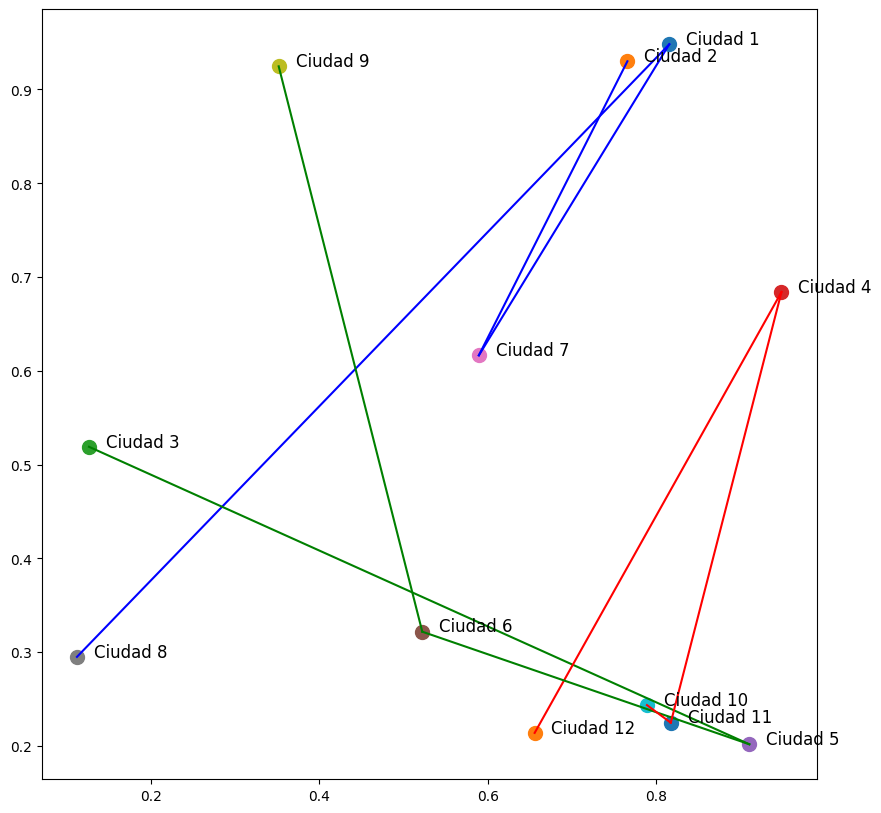

In [ ]:
#Esta vesion del problema (version sin minimizar los angulos the trpletas de 3 ciudades) minimiza las distancias totales de viaje entre las ciudades. Esta version se debe presentar.
num_ciudades = 12
num_vendedores = 3
capacidad=4
ciudades = range(0, num_ciudades+1)  # Incluye el CO (centro de operaciones) como ciudad 0
vendedores = range(1, num_vendedores+1)

# Ejemplo de distancias aleatorias (esto se puede reemplazar con tus distancias reales)
random.seed(5)
distancias = {(i, j): (0 if i == 0 or j == 0 else random.uniform(0.1, 1)) for i in ciudades for j in ciudades if i != j}

# Modelo
modelo = pulp.LpProblem("TSP_variant_with_CO", pulp.LpMinimize)

# Variables de decisión
x = pulp.LpVariable.dicts("x", (ciudades, ciudades, vendedores), cat='Binary')
u = pulp.LpVariable.dicts("u", (ciudades[1:], vendedores), 2,capacidad+1 , cat='Continuous') # num_ciudades+1

# Función objetivo
modelo += pulp.lpSum(distancias[i, j] * x[i][j][k] for i in ciudades for j in ciudades if i != j for k in vendedores)

# Restricciones
for i in ciudades[1:]:
    modelo += pulp.lpSum(x[i][j][k] for j in ciudades if i != j for k in vendedores) == 1

for k in vendedores:
    modelo += pulp.lpSum(x[i][j][k] for i in ciudades for j in ciudades if i != j) == capacidad+1

for i in ciudades:
    for k in vendedores:
        modelo += pulp.lpSum(x[i][j][k] for j in ciudades if i != j) == pulp.lpSum(x[j][i][k] for j in ciudades if i != j)

# Cada vendedor comienza (y termina- pero lo comentamos) en el centro de operaciones (CO)
for k in vendedores:
    modelo += pulp.lpSum(x[0][j][k] for j in ciudades if j != 0) == 1
    #modelo += pulp.lpSum(x[i][0][k] for i in ciudades if i != 0) == 1

for k in vendedores:
    for i in ciudades[1:]:
        for j in ciudades[1:]:
            if i != j:
                modelo += u[i][k] - u[j][k] + (capacidad + 1) * x[i][j][k] <= capacidad #capacidadnum_ciudades

# Resuelve el modelo
modelo.solve()

# Visualización
random.seed(5)
coords = {i: (random.uniform(0.1, 1), random.uniform(0.1, 1)) for i in ciudades}  # Coordenadas aleatorias, puedes reemplazarlo con tus datos
colors = ['r', 'g', 'b']

plt.figure(figsize=(10, 10))
# Esta parte dibuja los arcos entre ciudades sin incluir los arcos al centro de distribucion.
for i in ciudades:
    for j in ciudades:
        if i != j and (i!=0 and j!=0):
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:
                    plt.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color=colors[k-1])

for i in ciudades:

    if i != 0:
        plt.scatter(coords[i][0], coords[i][1], s=100)
        plt.text(coords[i][0]+.02, coords[i][1], f'Ciudad {i}', fontsize=12)

# Esta parte comentada dibuja el centro de distribucion y tambien los arcos entre ellos
#for i in ciudades:
#    for j in ciudades:
#        if i != j:
#            for k in vendedores:
#                if pulp.value(x[i][j][k]) == 1:
#                    plt.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color=colors[k-1])

#for i in ciudades:
#    plt.scatter(coords[i][0], coords[i][1], s=100)
#    if i == 0:
#        plt.text(coords[i][0]+2, coords[i][1], 'CO', fontsize=12)
#    else:
#        plt.text(coords[i][0]+2, coords[i][1], f'Ciudad {i}', fontsize=12)

plt.show()




x 0,2,3 = 1.0
x 0,3,2 = 1.0
x 0,10,1 = 1.0
x 1,8,3 = 1.0
x 2,7,3 = 1.0
x 3,5,2 = 1.0
x 4,12,1 = 1.0
x 5,6,2 = 1.0
x 6,9,2 = 1.0
x 7,1,3 = 1.0
x 8,0,3 = 1.0
x 9,0,2 = 1.0
x 10,11,1 = 1.0
x 11,4,1 = 1.0
x 12,0,1 = 1.0


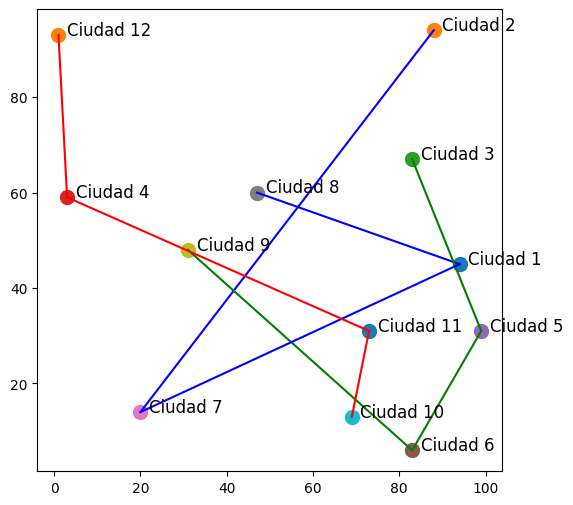

In [ ]:
for i in ciudades:
    for j in ciudades:
        if i != j:
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:
                  print(f'x {i},{j},{k} = {x[i][j][k].varValue}')

random.seed(5)
coords = {i: (random.randint(0, 100), random.randint(0, 100)) for i in ciudades}  # Coordenadas aleatorias, puedes reemplazarlo con tus datos
colors = ['r', 'g', 'b']

plt.figure(figsize=(6, 6))

for i in ciudades:
    for j in ciudades:
        if i != j and (i!=0 and j!=0):
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:
                    plt.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color=colors[k-1])

for i in ciudades:

    if i != 0:
        plt.scatter(coords[i][0], coords[i][1], s=100)
        plt.text(coords[i][0]+2, coords[i][1], f'Ciudad {i}', fontsize=12)



plt.show()


#Angles minimisation problem:

### Angles computation:

In [ ]:
import random
import numpy as np
def generate_coordinates(num_cities, seed=None):
    """
    Generates a list of random (x, y) coordinates.

    Parameters:
    - num_cities: Number of cities (coordinates) to generate.
    - seed: Random seed for reproducibility.


    Returns:
    - List of (x, y) tuples.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    #coordinates = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_cities)]
    coordinates = [(random.uniform(0.1, 1), random.uniform(0.1, 1)) for _ in range(num_cities)]
    #coordinates.append(('CO'))
    return coordinates
#Must be fixed so all arcs reelated to CO the cosine is 0!!!!
def compute_distance_matrix(coordinates):
    """
    Computes the distance matrix for a given list of coordinates.

    Parameters:
    - coordinates: List of (x, y) tuples.

    Returns:
    - Distance matrix (numpy array) where entry (i, j) is the distance between city i and city j.
    """
    num_cities = len(coordinates)+1 #CO included
    distance_matrix = np.zeros((num_cities, num_cities))
    #print(distance_matrix)
    #print()
    for i in range(num_cities):
        for j in range(i+1, num_cities):
          if i==0 or j==0:
            distance =0
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
            #print(distance_matrix)
            #print()
          else:
            x1, y1 = coordinates[i-1]
            x2, y2 = coordinates[j-1]
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance  # Matrix is symmetric
            #print(distance_matrix)
            #print()
    return distance_matrix

def compute_cosI(distance_matrix, coordinates):
    """
    Computes the angles formed by sets of three cities.

    Parameters:
    - distance_matrix: Distance matrix (numpy array) where entry (i, j) is the distance between city i and city j.
    - coordinates: List of (x, y) tuples.

    Returns:
    - List of angles (in radians) for each set of three cities.
    """
    num_cities = len(coordinates)
    cosines = np.zeros((num_cities, num_cities,num_ciudades))
    #cosines = []

    for i in range(num_cities):
        for j in range(num_cities):
            for k in range(num_cities):
                if i != j and i != k and j != k:
                    # Vector from i to j
                    vec_ji = np.array(coordinates[i][0]) - np.array(coordinates[j][0])
                    # Vector from i to k
                    vec_jk = np.array(coordinates[k][0]) - np.array(coordinates[j][0])

                    # Compute the angle using dot product
                    cos_theta = np.dot(vec_ji, vec_jk) / (np.linalg.norm(vec_ji) * np.linalg.norm(vec_jk)) # all vectors going out from the mid vertex
                    #theta = np.pi-np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clipping is used to handle numerical errors, No need of this if the cosine is closer to -1 that is what we want

                    #cosines.append((i, j, k, cos_theta))
                    cosines[i][j][k]=cos_theta

    return cosines

def compute_cosII(distance_matrix, coordinates):
    """
    Computes the angles formed by sets of three cities.

    Parameters:
    - distance_matrix: Distance matrix (numpy array) where entry (i, j) is the distance between city i and city j.
    - coordinates: List of (x, y) tuples.

    Returns:
    - List of angles (in radians) for each set of three cities.
    """
    num_cities = len(coordinates)+1
    #cosines = []
    cosines = np.zeros((num_cities, num_cities,num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            for k in range(num_cities):
                if i != j and i != k and j != k:
                  if i==0 or j==0 or k==0:        #Revise  this
                    cos_theta=-1
                    #cosines.append((i, j, k, cos_theta))
                    cosines[i][j][k]=cos_theta
                  else: #revise from here downwards!!!! vector for angles are wrong!!
                    # Vector from i to j
                    #vec_ji = np.array(coordinates[i-1][0]) - np.array(coordinates[j-1][0])
                    vec_ji = np.array(coordinates[i-1]) - np.array(coordinates[j-1])
                    # Vector from i to k
                    #vec_jk = np.array(coordinates[k-1][0]) - np.array(coordinates[j-1][0])
                    vec_jk = np.array(coordinates[k-1]) - np.array(coordinates[j-1])

                    # Compute the angle using dot product
                    cos_theta = np.dot(vec_ji, vec_jk) / (np.linalg.norm(vec_ji) * np.linalg.norm(vec_jk)) # all vectors going out from the mid vertex
                    #theta = np.pi-np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clipping is used to handle numerical errors, No need of this if the cosine is closer to -1 that is what we want
                    #print(cos_theta)
                    #cosines.append((i, j, k, cos_theta))
                    cosines[i][j][k]=cos_theta

    return cosines

def dot_product(x1, y1, x2, y2):
    return x1 * x2 + y1 * y2

def magnitude(x, y):
    return (x**2 + y**2)**0.5

In [ ]:
coords = generate_coordinates(12, seed=42)
print(coords[0])
dist_matrix = compute_distance_matrix(coords)
print(dist_matrix[1][2])

#cosines = compute_cosI(dist_matrix, coords)
#for i in range(len(cosines)):
 # for j in range(len(cosines)):
  #  for k in range(len(cosines)):
   #   print(f"cosine formed by cities {i}, {j}, and {k}: {cosines[i,j,k]:.2f}")
#print()
cosines = compute_cosII(dist_matrix, coords)
#print(cosines[0][2][3])
#for i in range(len(cosines)):
  #for j in range(len(cosines)):
    #for k in range(len(cosines)):
      #print(f"cosine formed by cities {i}, {j}, and {k}: {cosines[i,j,k]:.2f}")
#print()
#print(cosines)

# Ya tenemos que todos los cosenos de las tripletas relacionadas con el CO son -1.'

#print(dist_matrix)
#print(len(coords))

(0.6754841186120953, 0.12250967970040025)
0.3733305411412863


In [ ]:
coords = generate_coordinates(12, seed=42)
dist_matrix = compute_distance_matrix(coords)

num_cities = len(coords)+1

cosines = np.zeros((num_cities, num_cities,num_cities))

for i in range(num_cities):
    for j in range(num_cities):
        for k in range(num_cities):
            if i != j and i != k and j != k:
              if i==0 or j==0 or k==0:
                cos_theta=-1
                cosines[i][j][k]=cos_theta
              else:
                    # Vector from i to j
                vec_ij = np.array(coords[j-1]) - np.array(coords[i-1])
                    # Vector from i to k
                vec_ik = np.array(coords[k-1]) - np.array(coords[i-1])

                    # Compute the angle using dot product
                cos_theta = np.dot(vec_ij, vec_ik) / (np.linalg.norm(vec_ij) * np.linalg.norm(vec_ik))
                    #theta = np.pi-np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clipping is used to handle numerical errors, No need of this if the cosine is closer to -1 that is what we want

                    #cosines.append((i, j, k, cos_theta))
                cosines[i][j][k]=cos_theta



# This is an intend to make a compund set and then make a tighter formulation of the problem:

In [ ]:
#Initial Solution- set construction
num_ciudades = 12
num_vendedores = 3
capacidad=4
capacidad=range(0,capacidad+1)
ciudades = range(0, num_ciudades+1)
vendedores = range(1, num_vendedores+1)
Initial_solution=[]
for k in vendedores:
  for i in capacidad:
    #print(f'({i},{i+1},{k})')
    if i<(len(capacidad)-1):
      if i==0:
        Initial_solution.append((0,i+(len(capacidad)-1)*(k-1)+1,k))
        #print(f'({0},{i+(len(capacidad)-1)*(k-1)+1},{k})')
      else:
        #print(f'({i+(len(capacidad)-1)*(k-1)},{i+(len(capacidad)-1)*(k-1)+1},{k})')
        Initial_solution.append((i+(len(capacidad)-1)*(k-1),i+(len(capacidad)-1)*(k-1)+1,k))
    else:
          #print(f'({i+(len(capacidad)-1)*(k-1)},{0},{k})')
          Initial_solution.append((i+(len(capacidad)-1)*(k-1),0,k))
print(Initial_solution)
"""
Here is a piece of code that make the set for the initial solution which is the merely
all the cities visited in order, by each vendor, vendors should be multiple of the cities otherwise will not work
as well as the capacity or the number of cities visited
"""

[(0, 1, 1), (1, 2, 1), (2, 3, 1), (3, 4, 1), (4, 0, 1), (0, 5, 2), (5, 6, 2), (6, 7, 2), (7, 8, 2), (8, 0, 2), (0, 9, 3), (9, 10, 3), (10, 11, 3), (11, 12, 3), (12, 0, 3)]


'\nHere is a piece of code that make the set for the initial solution which is the merely\nall the cities visited in order, by each vendor, vendors should be multiple of the cities otherwise will not work\nas well as the capacity or the number of cities visited\n'

In [ ]:
print(cosines[1][2][3])

0.34320852938863833


Mathematical Model minimising the angles and distances

In [ ]:
#Esta vesion del problema (version sin minimizar los angulos the trpletas de 3 ciudades) minimiza las distancias totales de viaje entre las ciudades. Esta version se debe presentar.
num_ciudades = 12
num_vendedores = 3
capacidad=4
alpha=2 #objective percentage priority alpha-[0,1] si alpha<1 el coseno del angulo tendra menos importancia que el termino de distancia. checkiing this in 10 not feasible solution
ciudades = range(0, num_ciudades+1)  # Incluye el CO (centro de operaciones) como ciudad 0
vendedores = range(1, num_vendedores+1)


coords = generate_coordinates(num_ciudades, seed=42)
dist_matrix = compute_distance_matrix(coords)
cosines = compute_cosII(dist_matrix, coords) #This one produce a matrix and should be used with generate_coordinates function

#otro problema
City_obj=Cities(num_ciudades)
coords_1=City_obj.gen_coords_SAI(num_ciudades)
cosines_1=City_obj.cos_SAI(coords_1)
dist_matrix_1=City_obj.dist_mat_SAI(coords_1)
Z_BASELINE = City_obj.objective_comp(coords_1,num_vendedores,dist_matrix_1,cosines_1,alpha)
M=1e6



# Modelo
modelo = pulp.LpProblem("TSP_variant_with_CO", pulp.LpMinimize)

# Variables de decisión
z = pulp.LpVariable("z", cat='Binary') #object disjuntive


x = pulp.LpVariable.dicts("x", (ciudades, ciudades, vendedores), cat='Binary')
u = pulp.LpVariable.dicts("u", (ciudades[1:], vendedores), 2,capacidad+1 , cat='Continuous') # num_ciudades+1
y = pulp.LpVariable.dicts("y", (ciudades, ciudades, ciudades, vendedores),cat='Binary') #linearizante

Z = pulp.LpVariable("Z",cat='Continuous') #obj func

# Definir la función objetivo
objective = pulp.LpAffineExpression()

# Término correspondiente a la distancia
for k in vendedores:
    for i in ciudades:
        for j in ciudades:
            if i != j:
                objective += dist_matrix[i, j] * x[i][j][k] # 0 to check a thing

                Z += dist_matrix[i, j] * x[i][j][k]# objc
# Término correspondiente al ángulo
for k in vendedores:
    for i in ciudades:
        for j in ciudades:
            for m in ciudades:
                if i != j and j != m:
                    objective += y[i][j][m][k] * cosines[i][j][m]*alpha

                    Z += y[i][j][m][k] * cosines[i][j][m]*alpha


# Añadir la función objetivo al modelo
modelo += objective

# Restricciones
for i in ciudades[1:]:
    modelo += pulp.lpSum(x[i][j][k] for j in ciudades if i != j for k in vendedores) == 1

for k in vendedores:
    modelo += pulp.lpSum(x[i][j][k] for i in ciudades for j in ciudades if i != j) == capacidad+1

for i in ciudades:
    for k in vendedores:
        modelo += pulp.lpSum(x[i][j][k] for j in ciudades if i != j) == pulp.lpSum(x[j][i][k] for j in ciudades if i != j)

# Cada vendedor comienza (y termina- pero lo comentamos) en el centro de operaciones (CO)
for k in vendedores:
    modelo += pulp.lpSum(x[0][j][k] for j in ciudades if j != 0) == 1
    modelo += pulp.lpSum(x[i][0][k] for i in ciudades if i != 0) == 1 # This must act as a symmetry breaker constrain.

for k in vendedores:
    for i in ciudades[1:]:
        for j in ciudades[1:]:
            if i != j:
                modelo += u[i][k] - u[j][k] + (capacidad + 1) * x[i][j][k] <= capacidad #capacidadnum_ciudades
# Linearization
for i in ciudades:
    for j in ciudades:
        if i != j:
            for m in ciudades:
                if j != m:
                    for k in vendedores:
                        modelo += y[i][j][m][k] <= x[i][j][k]
                        modelo += y[i][j][m][k] <= x[j][m][k]
                        modelo += y[i][j][m][k] >= x[i][j][k] + x[j][m][k] - 1

# Add the conditional constraints based on the feasible solution.
for (i, j, k) in Initial_solution: # must run cell before
    modelo += x[i][j][k] <= 1 + M*z
    modelo += x[i][j][k] >= 1 - M*z

#Feasible solution faster
modelo += Z <= Z_BASELINE + M*(1-z)

#TODO: Resticcion de symetria

# Resuelve el modelo
modelo.solve(pulp.PULP_CBC_CMD(options=["sec=285"])) #despues de 6 minutos para asi no haya encontrado la solucion optima.

# I have to update the class or do even a new class child of it, that has this tighten formulation

1

In [ ]:
for i in ciudades:
    for j in ciudades:
        if i != j and (i!=0 and j!=0):
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:
                  print(f'x[{i}][{j}][{k}]')

len(coords)
z=pulp.value(modelo.objective)
print(z)
print()
print(cosines[7][8][2])
print(cosines[1][6][10])
print(np.arccos(cosines[1][6][10]))
print()
print(pulp.value(modelo.objective))

x[1][4][2]
x[2][8][1]
x[3][11][1]
x[5][6][3]
x[6][9][3]
x[7][12][2]
x[8][3][1]
x[10][5][3]
x[12][1][2]
-25.342490740444703

0.9795810489210286
0.9887461771175311
0.1501665378608595

-25.342490740444703


In [ ]:
print(pulp.value(modelo.objective))

-15.376629125825376


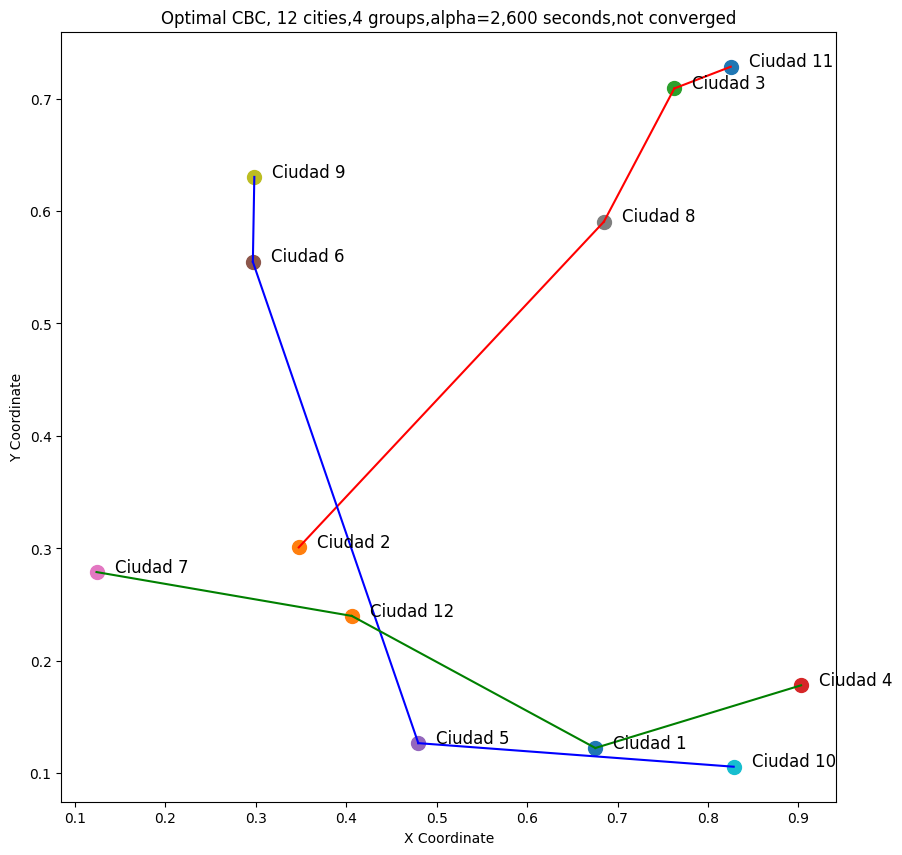

In [ ]:
# arreglar la grafica de la solucion
random.seed(42)
#coords = {i: (random.randint(0, 100), random.randint(0, 100)) for i in ciudades}  # Coordenadas aleatorias, puedes reemplazarlo con tus datos
colors = ['r', 'g', 'b']

plt.figure(figsize=(10, 10))
# Esta parte dibuja los arcos entre ciudades sin incluir los arcos al centro de distribucion.
for i in ciudades:
    for j in ciudades:
        if i != j and (i!=0 and j!=0):
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:

                    plt.plot([coords[i-1][0], coords[j-1][0]], [coords[i-1][1], coords[j-1][1]], color=colors[k-1])

for i in ciudades:

    if i != 0:
        plt.scatter(coords[i-1][0], coords[i-1][1], s=100)
        plt.text(coords[i-1][0]+0.02, coords[i-1][1], f'Ciudad {i}', fontsize=12)

plt.title('Optimal CBC, 12 cities,4 groups,alpha=2,600 seconds,not converged')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Esta parte comentada dibuja el centro de distribucion y tambien los arcos entre ellos
#for i in ciudades:
#    for j in ciudades:
#        if i != j:
#            for k in vendedores:
#                if pulp.value(x[i][j][k]) == 1:
#                    plt.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color=colors[k-1])

#for i in ciudades:
#    plt.scatter(coords[i][0], coords[i][1], s=100)
#    if i == 0:
#        plt.text(coords[i][0]+2, coords[i][1], 'CO', fontsize=12)
#    else:
#        plt.text(coords[i][0]+2, coords[i][1], f'Ciudad {i}', fontsize=12)

plt.show()
# corregir la parte del angulo

#Mathematical Model as a MILP:
\begin{align*}
\textbf{Parameters:} \\
& d_{i,j} \text{: Distance between city } i \text{ and city } j \\
& \alpha \text{: Weighting factor for the angle objective} \\
& \theta_{i,j,m} \text{: Angle between cities } i, j, \text{ and } m \\
& Ca \text{: Capacity (number of cities a vendor can visit excluding the operation center)} \\
& V \text{: Set of vendors} \\
& C \text{: Set of cities including the operation center} \\
\\
\textbf{Decision Variables:} \\
& x_{i,j,k} \text{: Binary. 1 if vendor } k \text{ travels from city } i \text{ to city } j, \text{ 0 otherwise.} \\
& y_{i,j,m,k} \text{: Binary. 1 if the path from city } i \text{ to } j \text{ to } m \text{ is taken by vendor } k, \text{ 0 otherwise.} \\
& u_{i,k} \text{: Continuous. Represents the order of visitation for city } i \text{ by vendor } k. \\
\\
\text{Minimize} \quad Z &= (1-\alpha) \times \sum_{k \in V} \sum_{i \in C} \sum_{j \in C, j \neq i} d_{i,j} \times x_{i,j,k} + \alpha \times \sum_k \sum_i \sum_j \sum_m y_{i,j,m,k} \cos(\theta_{i,j,m}) \\
\text{subject to:} \\
& \sum_{j \in C, j \neq i} \sum_{k \in V} x_{i,j,k} = 1 & \forall i \in C, i \neq 0 \quad \text{(a) All sites must be visited} \\
& \sum_{i \in C} \sum_{j \in C, j \neq i} x_{i,j,k} = Ca+1 & \forall k \in V \quad \text{(b) Each vendor must visit Ca + 1 site, 1 because includes the Depot} \\
& \sum_{j \in C, j \neq i} x_{i,j,k} = \sum_{j \in C, j \neq i} x_{j,i,k} & \forall i \in C, i \neq 0, \forall k \in V \quad \text{(c) Flow Balance} \\
& \sum_{j \in C, j \neq 0} x_{0,j,k} = 1 & \forall k \in V \quad \text{(d) The first site visitted is the Depot and Symmetry Constrain} \\
& \sum_{i \in C, i \neq 0} x_{i,0,k} = 1 & \forall k \in V \quad \text{(e) Last site visited is the Depot} \\
& u_{i,k} - u_{j,k} + (Ca + 1) x_{i,j,k} \leq Ca & \forall i,j \in C, i \neq j, \forall k \in V \quad \text{(f) Subtour constrain for each vendor} \\
& 2 \leq u_{i,k} \leq Ca+1 & \forall i \in C, i \neq 0, \forall k \in V \quad \text{(g) Domain of axualiary variables u} \\
& y_{i,j,m,k} \leq x_{i,j,k} & \forall i,j,m \in C, i \neq j, j \neq m, \forall k \in V \quad \text{(h) Linearization constrain(1)} \\
& y_{i,j,m,k} \leq x_{j,m,k} & \forall i,j,m \in C, i \neq j, j \neq m, \forall k \in V \quad \text{(i)Linearization constrain(2)} \\
& y_{i,j,m,k} \geq x_{i,j,k} + x_{j,m,k} - 1 & \forall i,j,m \in C, i \neq j, j \neq m, \forall k \in V \quad \text{(j)Linearization constrain(3)} \\
& x_{i,j,k} \in \{0,1\} & \forall i,j \in C, \forall k \in V \quad \text{(k) Domain Constrain} \\
& y_{i,j,m,k} \in \{0,1\} & \forall i,j,m \in C, \forall k \in V \quad \text{(l)Domain Constrain} \\
\end{align*}

#Reusable implementation of the new problem:
TSP Variation problem.

In [ ]:
class Opt_TSPV_CBC:
  def __init__(self, a_number_of_cities,a_number_of_vendors,a_matrix_of_distances,a_cosines_matrix,a_vendorCapacity,a_weight_fact=0.5,a_full_problem=True):
    self.number_of_cities = a_number_of_cities
    self.number_of_vendors=a_number_of_vendors
    self.matrix_of_distances = a_matrix_of_distances
    self.Cities = list(range(0,self.number_of_cities+1))
    self.Vendors=list(range(1,self.number_of_vendors+1))
    self.cosines=a_cosines_matrix
    self.capacity=a_vendorCapacity
    self.weight_cosines=a_weight_fact
    self.full_problem=a_full_problem



  def solver_method(self):
    #Addition for tight constrain Cities class object
    City_obj=Cities(self.number_of_cities)
    coords=City_obj.gen_coords_SAI(self.number_of_cities,seed=42)
    #Lower bound for the objetive function, tight constrain
    Z_BASELINE = City_obj.objective_comp(coords,self.number_of_vendors,self.matrix_of_distances,self.cosines,self.weight_cosines)
    M=1e6
    #Creation of feasible solution as set
    capacidad=range(0,(self.number_of_cities//self.number_of_vendors)+1)
    #ciudades = range(0, num_ciudades+1)
    #vendedores = range(1, num_vendedores+1)
    Initial_solution=[]
    for k in self.Vendors:
      for i in capacidad:
        #print(f'({i},{i+1},{k})')
        if i<(len(capacidad)-1):
          if i==0:
            Initial_solution.append((0,i+(len(capacidad)-1)*(k-1)+1,k))
            #print(f'({0},{i+(len(capacidad)-1)*(k-1)+1},{k})')
          else:
            #print(f'({i+(len(capacidad)-1)*(k-1)},{i+(len(capacidad)-1)*(k-1)+1},{k})')
            Initial_solution.append((i+(len(capacidad)-1)*(k-1),i+(len(capacidad)-1)*(k-1)+1,k))
        else:
          #print(f'({i+(len(capacidad)-1)*(k-1)},{0},{k})')
          Initial_solution.append((i+(len(capacidad)-1)*(k-1),0,k))


    # create the problem
    Model= pulp.LpProblem("TSP_variant_with_CO", pulp.LpMinimize)
    # decision variables
    x = pulp.LpVariable.dicts("x", (self.Cities,self.Cities,self.Vendors), cat='Binary')
    u = pulp.LpVariable.dicts("u", (self.Cities[1:], self.Vendors), 2,self.capacity+1 , cat='Continuous') # num_ciudades+1
    y = pulp.LpVariable.dicts("y", (self.Cities, self.Cities, self.Cities, self.Vendors),cat='Binary') #linearisation
    w = pulp.LpVariable("w", cat='Binary') #object disjuntive
    Z = pulp.LpVariable("Z",cat='Continuous') #obj func

    #objective function
    objective = pulp.LpAffineExpression()

    # Distance term in OB_F
    for k in self.Vendors:
        for i in self.Cities:
            for j in self.Cities:
                if i != j:
                    objective += self.matrix_of_distances[i, j] * x[i][j][k]*(1-self.weight_cosines)
                    Z += self.matrix_of_distances[i, j] * x[i][j][k]*(1-self.weight_cosines)



    # Angles/Cosines term in OB_F
    if self.full_problem:
      for k in self.Vendors:
        for i in self.Cities:
            for j in self.Cities:
                for m in self.Cities:
                    if i != j and j != m:
                        objective += y[i][j][m][k] * self.cosines[i][j][m]*self.weight_cosines # change for minus cosine since error seeing the cosine computations
                        Z += y[i][j][m][k] * self.cosines[i][j][m]*self.weight_cosines# objc

    Model += objective

    # constraints self.Cities self.Vendors
    for i in self.Cities[1:]:
        Model += pulp.lpSum(x[i][j][k] for j in self.Cities if i != j for k in self.Vendors) == 1

    for k in self.Vendors:
        Model += pulp.lpSum(x[i][j][k] for i in self.Cities for j in self.Cities if i != j) == self.capacity+1

    for i in self.Cities:
        for k in self.Vendors:
            Model += pulp.lpSum(x[i][j][k] for j in self.Cities if i != j) == pulp.lpSum(x[j][i][k] for j in self.Cities if i != j)

    # Cada vendedor comienza (y termina- pero lo comentamos) en el centro de operaciones (CO) Symmetry Constrain
    for k in self.Vendors:
        Model += pulp.lpSum(x[0][j][k] for j in self.Cities if j != 0) == 1
        Model += pulp.lpSum(x[i][0][k] for i in self.Cities if i != 0) == 1

    for k in self.Vendors: #self.Cities self.Vendors
        for i in self.Cities[1:]:
            for j in self.Cities[1:]:
                if i != j:
                    Model += u[i][k] - u[j][k] + (self.capacity + 1) * x[i][j][k] <= self.capacity #capacidadnum_ciudades
    # Linearisation
    if self.full_problem:
      for i in self.Cities:
        for j in self.Cities:
          if i != j:
            for m in self.Cities:
              if j != m:
                for k in self.Vendors:
                  Model += y[i][j][m][k] <= x[i][j][k]
                  Model += y[i][j][m][k] <= x[j][m][k]
                  Model += y[i][j][m][k] >= x[i][j][k] + x[j][m][k] - 1

    #TODO: tighten
    # Add the conditional constraints based on the feasible solution.
    for (i, j, k) in Initial_solution: # must run cell before
        Model += x[i][j][k] <= 1 + M*w
        Model += x[i][j][k] >= 1 - M*w
    #Feasible solution faster ramification mechanism that allows solver to start from a feasible  solution known
    Model += Z <= Z_BASELINE + M*(1-w)


    # solve the problem
    status = Model.solve(pulp.PULP_CBC_CMD(options=["sec=600"])) # after 10 minutes (600) stop and after 290+ this formulation is able to provide a feasible solution

    # print the values of the matrix of x[i,j,k]
    print(LpStatus[status])
    for i in self.Cities:
        for j in self.Cities:
            if i != j and (i!=0 and j!=0):
                for k in self.Vendors:
                    if pulp.value(x[i][j][k]) == 1:
                      print(f'x[{i}][{j}][{k}]')

    #solution_edges=[edge for edge in self.edges if x[edge].varValue > 0.95]
    #print(prob)
    z=pulp.value(Model.objective)
    #print(pulp.value(x))

    return x,z


Test Class, same problem above:

In [ ]:
#Esta vesion del problema (version sin minimizar los angulos the trpletas de 3 ciudades) minimiza las distancias totales de viaje entre las ciudades. Esta version se debe presentar.
num_ciudades = 12
num_vendedores =3
capacidad=4
#alpha=1 #objective percentage priority alpha-[0,1] si alpha<1 el coseno del angulo tendra menos importancia que el termino de distancia.
#ciudades = range(0, num_ciudades+1)  # Incluye el CO (centro de operaciones) como ciudad 0
#vendedores = range(1, num_vendedores+1)


# Ejemplo de distancias aleatorias (esto se puede reemplazar con tus distancias reales)
coords = generate_coordinates(num_ciudades, seed=42)
dist_matrix = compute_distance_matrix(coords)
cosines = compute_cosII(dist_matrix, coords)
cosines=(cosines+1)/2 #normalizing the the cosines values from 0 to 1 rather than -1 to 1

new_problem=Opt_TSPV_CBC(num_ciudades,num_vendedores,dist_matrix,cosines,capacidad,a_weight_fact=0.5)

In [ ]:
#print(min(cosines),max(cosines))

In [ ]:
x,z=new_problem.solver_method()

Optimal
x[1][10][2]
x[2][12][1]
x[3][8][3]
x[5][1][2]
x[6][2][1]
x[8][7][3]
x[9][6][1]
x[10][4][2]
x[11][3][3]


In [ ]:
print(z)
ciudades = range(0, num_ciudades+1)  # Incluye el CO (centro de operaciones) como ciudad 0
vendedores = range(1, num_vendedores+1)

1.083437144742187


Test looking the solution in a plot:

Text(0, 0.5, 'Y Coordinate')

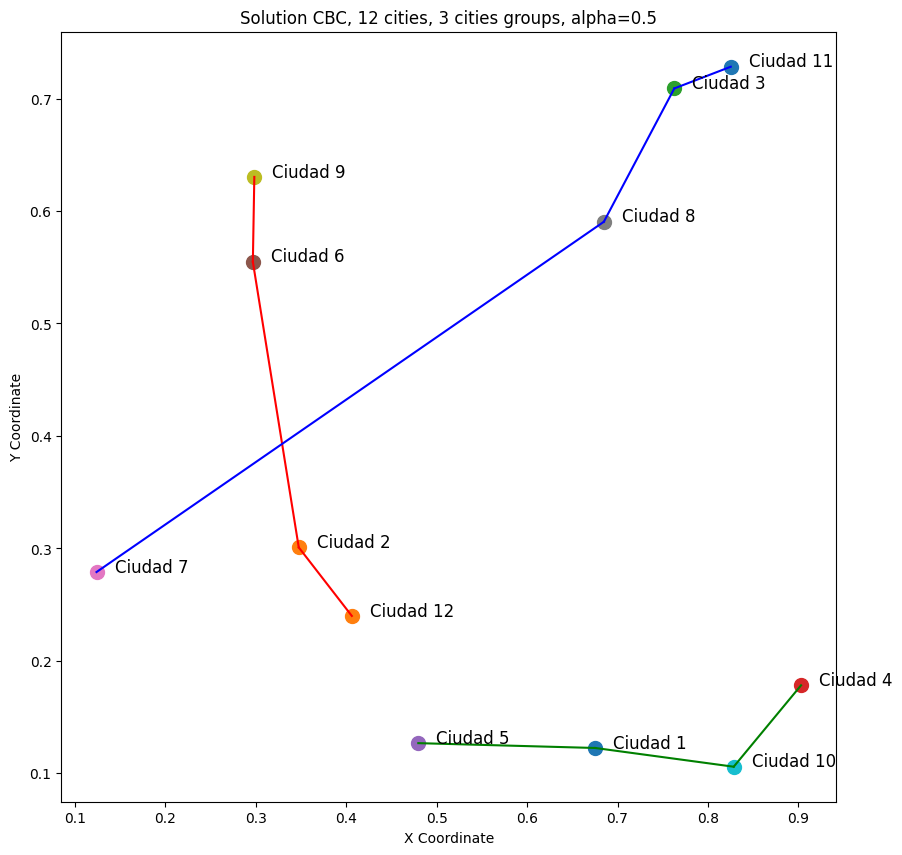

In [ ]:
colors = ['r', 'g', 'b']

plt.figure(figsize=(10, 10))
# Esta parte dibuja los arcos entre ciudades sin incluir los arcos al centro de distribucion.
for i in ciudades:
    for j in ciudades:
        if i != j and (i!=0 and j!=0):
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:

                    plt.plot([coords[i-1][0], coords[j-1][0]], [coords[i-1][1], coords[j-1][1]], color=colors[k-1])

for i in ciudades:

    if i != 0:
        plt.scatter(coords[i-1][0], coords[i-1][1], s=100)
        plt.text(coords[i-1][0]+0.02, coords[i-1][1], f'Ciudad {i}', fontsize=12)

plt.title(f'Solution CBC, {len(ciudades)-1} cities, {len(vendedores)} cities groups, alpha={0.5}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')



#SA implementation for this problem!!!
###helper functions


In [ ]:
class Heurist_SimAnn_NP: #NP means new problem

  def __init__(self,a_number_of_cities,a_num_travels, a_matrix_of_distances,a_matrix_of_cos,a_coordinates,a_max_iterations_out,a_max_iterations_in,a_factor2=.99,a_alpha_fac=1):
    self.coordinates=a_coordinates
    self.matrix_dis=a_matrix_of_distances
    self.matrix_cos=a_matrix_of_cos
    self.max_iter_in=a_max_iterations_in
    self.factor2=a_factor2 #guesstimation to check
    self.max_iter_out=a_max_iterations_out
    self.num_trav=a_num_travels
    self.num_cities=a_number_of_cities
    self.capacity=(self.num_cities//self.num_trav)
    self.alpha=a_alpha_fac

  def solver_method(self):

    #Simulated annealing algorithm

    # Initial Distance

    #objective=Cities.get_total_distance(self.matrix_of_distances,self.coordinates)
    objective=Cities.objective_comp(self.coordinates,self.num_trav,self.matrix_dis,self.matrix_cos,self.alpha)
    #print('obj is: ',objective)

    #INITIAL TEMPERATURE GETTING FROM HILLER T_initial>|Zn-Zc|
    T_ini=30
    T=T_ini
    #print('T is: ',T)
    coords=self.coordinates.copy()
    #print('initial sln: ',coords)

    #time to control the loop
    start_time = time.time()

    for _ in range(self.max_iter_out):
      T=T*self.factor2
      #breaking the outer loop after 600 seconds
      if time.time() - start_time >= 600:
        print("600 seconds have passed. Breaking the loop.")
        break


      for _ in range(self.max_iter_in):# max iterations is the same.
        #random generator of neighbor solutions
        r1,r2=np.random.randint(0,self.num_cities,size=2)
        #temp=coords[r1].copy()
        temp=coords[r1]
        coords[r1]=coords[r2]
        coords[r2]=temp
        # new distance of the candidate solution:
        #mat_dist=Cities.compute_dis(coords,self.number_of_cities)

        candidate=Cities.objective_comp(coords,self.num_trav,self.matrix_dis,self.matrix_cos,self.alpha)



        #check the performance new solution
        if candidate<objective:# choose new solution if better

          objective=candidate

        else:

          p=np.random.uniform()

          if p< np.exp((objective-candidate)/T): #choose worse sln with probability

            objective=candidate

          else: # Do not choose new solution
            temp=coords[r1]
            coords[r1]=coords[r2]
            coords[r2]=temp






    return objective,coords

## Test of the implementation 12 cities, 3 tours, 4 cities visitted in each tour:
### Parameters initialised:

In [ ]:
N=12
cap=4
number_of_travels=N//cap
City_obj=Cities(N)
coords=City_obj.gen_coords_SAI(N, seed=42)
dist_m=City_obj.dist_mat_SAI(coords)
cosines=City_obj.cos_SAI(coords)
print('Checking objective computation')
objective=City_obj.objective_comp(coords,number_of_travels,dist_m,cosines,alpha=3)
print(f'Objective : {objective}')

Checking objective computation
Objective : 16.036658434903423


### Running the problem:

In [ ]:
alpha=2 #for 10,20,50 the optimal solution is the same so the objective function is constant in alpha
NewP_opt_2=Heurist_SimAnn_NP(N,number_of_travels,dist_m,cosines,coords,a_max_iterations_in=500,a_max_iterations_out=1000,a_alpha_fac=alpha)#(a_number_of_cities=n,a_matrix_of_distances=matrix_dist,a_edges=edges,a_coordinates=coords,a_max_iterations_in=500,a_max_iterations_out=1000,a_factor2=0.99) #a_max_iterations=10,a_factor1=0.2,a_factor2=0.994,a_max_iterations=20,a_factor1=0.2,a_factor2=0.993

Solution1=NewP_opt_2.solver_method()

In [ ]:
print(Solution1[0])
print(Solution1[1])

-8.497304092644818
[((0.4797296377167434, 0.12681749749426333), 4), ((0.6754841186120953, 0.12250967970040025), 0), ((0.828487411010044, 0.10584888371025492), 9), ((0.9029616109343609, 0.17824494936647456), 3), ((0.8252373266495271, 0.7283254554894042), 10), ((0.7628240927476112, 0.7090295386806201), 2), ((0.6848959940015709, 0.590447332542895), 7), ((0.12388237271547727, 0.2789538856179836), 6), ((0.29839655983662705, 0.6303391154883179), 8), ((0.29677417732324307, 0.5548197592930262), 5), ((0.34752638653220735, 0.3008896643339405), 1), ((0.4062254648661927, 0.2399315498306034), 11)]


##Visualisation:

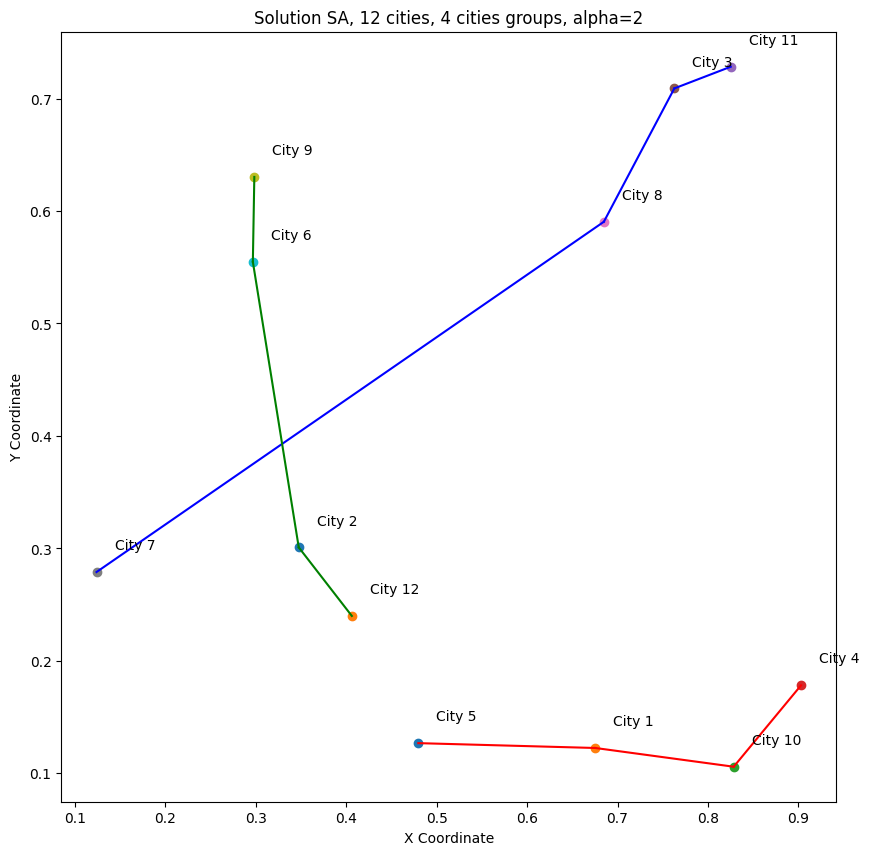

In [ ]:
###Twick this to plot the solution



# Form 3 groups of 4 cities each
number_of_cities_cap=4
groups = [Solution1[1][i:i+number_of_cities_cap] for i in range(0, N, number_of_cities_cap)]

#print(groups[0][0])
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green']

# Plot the cities
for coord in Solution1[1]:
    plt.scatter(coord[0][0],coord[0][1])
    plt.annotate(f'City {coord[1]+1}', (coord[0][0]+.02, coord[0][1]+.02))

# Connect cities in the same group
for group, color in zip(groups, colors):
    #for i in range(3):  # Connect each city to the next city in the group
        plt.plot([group[i][0][0], group[i+1][0][0]],
                [group[i][0][1], group[i+1][0][1]], color=color)

plt.title(f'Solution SA, 12 cities, 4 cities groups, alpha={alpha}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

###Experimients: 10,20,50,100,200 visitting 5 cities:

In [ ]:
#TODO:Experiment but I will do once I have the GA implemented

In [ ]:
#TODO:arreglar alpha
class Heurist_GA_NP:

  @staticmethod
  def get_initial_pop(a_coordinates,a_initial_pop_size=50):
    nodes=len(a_coordinates)
    a=range(nodes)
    initial_population=[]
    for _ in range(a_initial_pop_size):
      order=np.random.choice(a=a, size=nodes, replace=False)
      initial_population.append([a_coordinates[i] for i in order])
    return initial_population

  @staticmethod
  def selection_tour_op(a_population,a_num_of_travels,a_dist_m,a_cosines,An_alpha,a_tourn_size=10): #Selection by tournament. Coverges very quickly for this problem, not good , stops in a local optima.
    # See alternatives. Sample a subset of the population, and then with that subset make the tournament, select a parent and repeat the process for the number of parents.
    city_obj=Cities(len(a_population[0]))
    a=range(len(a_population))
    order=np.random.choice(a=a, size=a_tourn_size, replace=False)
    tournament_pop=[a_population[i] for i in order]
    #print(tournament_pop)
    fitness_tournament={}

    for i in range(len(tournament_pop)):
      fitness_tournament[(i)]=city_obj.objective_comp(tournament_pop[i],a_num_of_travels,a_dist_m,a_cosines,alpha=An_alpha)
    #print(fitness_tournament)

    parents_idx = sorted(fitness_tournament, key=fitness_tournament.get, reverse=False)[:2] #min thus reverse False
    #print('parents index in tournament population',parents_idx)
    parents=[tournament_pop[parents_idx[0]],tournament_pop[parents_idx[1]]]  # gentting the parents
    return parents

  @staticmethod
  def selection_roul_op(a_population,a_num_of_travels,a_dist_m,a_cosines,An_alpha):
     #Selection by tournament. Coverges very quickly for this problem, not good , stops in a local optima.
     city_obj=Cities(len(a_population[0]))
     #fitness since it is the minimum the desired
     fitn_values=[city_obj.objective_comp(ind,a_num_of_travels,a_dist_m,a_cosines,alpha=An_alpha) for ind in a_population]
     min_scaled=abs(min(fitn_values))
     #inverse for the minimum porblem
     inv_fit_val=[1.0 / (1.0 + f +min_scaled ) for f in fitn_values]
     total_fitness=sum(inv_fit_val)
     #total_fitness = sum(1.0/(city_obj.objective_comp(ind,a_num_of_travels,a_dist_m,a_cosines,alpha=An_alpha)+1.0) for ind in a_population)
     #Two points for the two parents
     selection_points = np.random.uniform(0, total_fitness,size=2)
     # Sorting to further cutting
     selection_points=np.sort(selection_points)
     #List to be able to use the pop from list object
     selection_points=list(selection_points)
     #Showing the selected points
     #for i in selection_point:
     # print(f'The point selected is: {i}')

     #Current sum init and parents init
     current_sum = 0
     #parents=[]
     #looping over the initial pop assessing the place where the selected points are
     #parent=[ind for ind in a_population if]
     parent=[]
     #print(f'the points selected are {selection_points[0]} and {selection_points[1]}')
     for point in selection_points:
      #print('selected point: ',point)
      for fit_val,ind in zip(inv_fit_val,a_population):
        current_sum+=fit_val
        #print('current sum: ',current_sum)
        if (current_sum > point):
          parent.append(ind)
          #print('Parent selected: ',ind)
          current_sum=0
          break
     #print()
     #print(f'selected point:{selection_points[0]}')
     #for ind in a_population:
      #fit_val=1.0/(city_obj.objective_comp(ind,a_num_of_travels,a_dist_m,a_cosines,alpha=An_alpha)+1.0)
      #print(f'the fitness value is:{fit_val}')
      #current_sum += fit_val
      #print(f'the current_sum value is:{current_sum}')
      #if this condition holds means it found the selected point so recording in the parents list
      #There is a problem here, when all the populations chromosomes are the same somthing is happening, I will be solving this tomorrow.26/09/2023
      #if (current_sum > selection_points[0]):
        #print(f'selected chromosome, since {current_sum} > {selection_point[0]}.')
        #parents.append(ind)
        #print(f'Parents selected:{ind}')
        #As selection_point is sorted take away the element 0
        #if len(selection_points)>1:
          #selection_points.pop(0)
          #print(f'selected point:{selection_points[0]}')
        # When there is one element is because there are no more selected points so exit the for loop
        #else:
          #break
     #print('selected_point',selection_point)
     #print('parents len:',len(parents))
     #print('parent len:',len(parent))

     return parent#parents,parent


  @staticmethod
  def cross_op(a_parents):

    #print('parents length: ',len(a_parents))
    par_1=a_parents[0]
    par_2=a_parents[1]

    offspring1=Heurist_GA_NP.offspirng_creation_op(par_1,par_2)
    offspring2=Heurist_GA_NP.offspirng_creation_op(par_2,par_1)

    return offspring1,offspring2



  @staticmethod
  def offspirng_creation_op(a_par1,a_par2):

    r=np.random.randint(0,len(a_par1))
    #print('r: ',r)
    offspring=a_par1[:r]
    offspring=list(offspring)
    #print('offspring before cross :',offspring)
    mask=[item not in offspring for item in a_par2]
    for i in range(len(mask)):
        if mask[i]:
          offspring.append(a_par2[i])
    #print('offspring after cross :',offspring)
    return offspring

  @staticmethod
  def mutation_op(child):

    r=np.random.randint(0,len(child),size=2)
    #print('r1: ',r[0])
    #print('r2: ',r[1])
    temp=child[r[0]]
    #print('temp: ',temp)
    child[r[0]]=child[r[1]]
    #print('child: ',child)
    child[r[1]]=temp
    #print('child after mutation: ',child)

    return child

  @staticmethod
  def genetic_process_1(a_coordinates,a_num_of_travels,a_dist_m,a_cosines,a_alpha,a_num_generation=500,a_cross=0.98,a_mutation=0.035,a_population_size=50):


    #Generating initial population
    initial_population=Heurist_GA_NP.get_initial_pop(a_coordinates,a_initial_pop_size=a_population_size)
    #print(f'initial population size: {len(initial_population)}, the first chromosome: {initial_population[0]}')

    #Selecting the parents:
    parents=Heurist_GA_NP.selection_tour_op(initial_population,a_num_of_travels,a_dist_m,a_cosines,An_alpha=a_alpha,a_tourn_size=a_population_size)
    #print(f'initial parents number: {len(parents)}, the first parent: {parents[0]}')

    #print()

    for i in range(a_num_generation):

      population=[]
      #print(f'start of the generation {i}')
      for j in range(a_population_size//2):
        #Generating probability for crossing
        p_crossing=random.uniform(0, 1)
        #Crossing with a_cross probablity
        if a_cross > p_crossing:
          children=Heurist_GA_NP.cross_op(parents)
         # print(f'In par of chromosones {j}, occured a crossing')
        else:
          children=parents
         # print(f'In par of chromosones {j}, not occured a crossing')

        #two children

        for child in children:
          #Mutation with a_mutation probablity
          p_mutation=random.uniform(0, 1)
          if a_mutation > p_mutation:
            population.append(Heurist_GA_NP.mutation_op(child))
          #  print(f'In par of chromosones {j}, occured a MUTATION!! in one child')
          else:
            population.append(child)
        #    print(f'In par of chromosones {j}, not occured a mutation in one child')
       # print(f'the generation {i} has a population size of {len(population)}')
      #Selecting the parents new generation:
      #print(f'population size in generation {i}: {len(population)}')
      #print()
      parents=Heurist_GA_NP.selection_tour_op(population,a_num_of_travels,a_dist_m,a_cosines,An_alpha=a_alpha,a_tourn_size=a_population_size)
      #print(f'parents number: {len(parents)} for generation {i+1}, the first parent: {parents[0]}')


    return parents

    #This is a different methaheuristic but the same pple but the population evolves rather than being created in each generation
  @staticmethod
  def genetic_process_2(a_coordinates,a_num_of_travels,a_dist_m,a_cosines,a_alpha,a_num_generation=500,a_cross=0.999,a_mutation=0.035,a_population_size=50):

      #Population Initialisation
      population=Heurist_GA_NP.get_initial_pop(a_coordinates,a_initial_pop_size=a_population_size)
      #For using the class Cities fucntion
      city_obj=Cities(len(population[0]))
      #this will be the main loop for all generations
      for i in range(a_num_generation):
        #print('generation: ',i)
        # Number to pick the kind of selection to be applied at the moment roulette and tournament occurs in avegrage 50/50: if the number is alter would be 66/33
        p_type_sel=order=np.random.choice(2)

        if p_type_sel==1:
          parents=Heurist_GA_NP.selection_tour_op(population,a_num_of_travels,a_dist_m,a_cosines,An_alpha=a_alpha)
        else:
          parents=Heurist_GA_NP.selection_roul_op(population,a_num_of_travels,a_dist_m,a_cosines,An_alpha=a_alpha)
        #Generating probability for crossing
        p_crossing=random.uniform(0, 1)
        if a_cross > p_crossing:
          children=Heurist_GA_NP.cross_op(parents)
         # print(f'In par of chromosones {j}, occured a crossing')
        else:
          children=parents

        #Mutation operation but it happens to be when a probability is got it
        for child in children:
          #Mutation with a_mutation probablity
          p_mutation=random.uniform(0, 1)
          if a_mutation > p_mutation:
            population.append(Heurist_GA_NP.mutation_op(child))
          #  print(f'In par of chromosones {j}, occured a MUTATION!! in one child')
          else:
            population.append(child)

        #This is the updating of the population with those with better fitness function
        population=sorted(population, key=lambda ind: city_obj.objective_comp(ind,a_num_of_travels,a_dist_m,a_cosines,alpha=a_alpha))
        population = population[:a_population_size]

      return population[:2]






test first method: Initial population creator


In [ ]:
N=12
cap=4
number_of_travels=N//cap
alpha=2
mutation_r=0.035#0.045 #0.035
City_obj=Cities(N)
coords=City_obj.gen_coords_SAI(N, seed=42)
dist_m=City_obj.dist_mat_SAI(coords)
cosines=City_obj.cos_SAI(coords)
ini_pop=Heurist_GA_NP.get_initial_pop(a_coordinates=coords,a_initial_pop_size=100)
a=Heurist_GA_NP.selection_roul_op(a_population=ini_pop,a_num_of_travels=number_of_travels,a_dist_m=dist_m,a_cosines=cosines,An_alpha=alpha)
#b=Heurist_GA_NP.selection_tour_op(a_population=ini_pop,a_num_of_travels=number_of_travels,a_dist_m=dist_m,a_cosines=cosines,An_alpha=alpha)
#print(f'parent_1: {a[0]}')
solutions=Heurist_GA_NP.genetic_process_2(a_coordinates=coords,a_num_of_travels=number_of_travels,a_dist_m=dist_m,a_cosines=cosines,a_num_generation=600,a_cross=0.98,a_mutation=mutation_r,a_population_size=200,a_alpha=alpha)
#objective_func=Cities.objective_comp(solutions[1],number_of_travels,dist_m,cosines,alpha=alpha)
solutions2=Heurist_GA_NP.genetic_process_1(a_coordinates=coords,a_num_of_travels=number_of_travels,a_dist_m=dist_m,a_cosines=cosines,a_num_generation=600,a_cross=0.98,a_mutation=mutation_r,a_population_size=200,a_alpha=alpha)
#print(objective_func)
#print()
#print('Roulette')
#print(f'first parent:{a[0]} \nthe second parent is:{a[1]}')
#print()
#print('Tournament')
#print(f'first parent:{a[0][0]} \nthe second parent is:{a[0][1]}')
#print()
#print('Tournament')
#print(f'first parent:{a[1][0]} \nthe second parent is:{a[1][1]}')
#print(len(a[0]))

#print(f'Checking some solutions:\nvalue of 1st best gen_0: {City_obj.objective_comp(a[0],3,dist_m,cosines,alpha)}\nvalue of 2nd best gen_0: {City_obj.objective_comp(a[1],3,dist_m,cosines,alpha)}\nvalue of any in population gen_0: {City_obj.objective_comp(ini_pop[1],3,dist_m,cosines,alpha)}')
print(len(solutions))

2


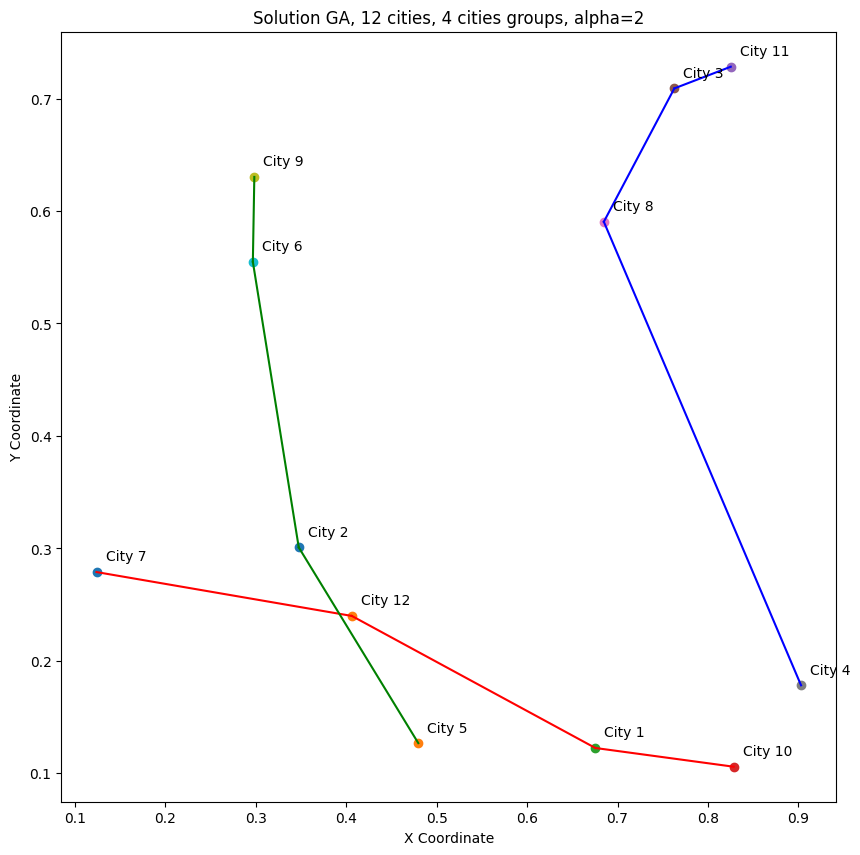

In [ ]:
# Form 3 groups of 4 cities each
#solutions=b

number_of_cities_cap=4
groups = [solutions[0][i:i+number_of_cities_cap] for i in range(0, N, number_of_cities_cap)]

#print(groups[0][0])
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green']

# Plot the cities
for coord in solutions[0]:
    plt.scatter(coord[0][0],coord[0][1])
    plt.annotate(f'City {coord[1]+1}', (coord[0][0]+.01, coord[0][1]+.01))

# Connect cities in the same group
for group, color in zip(groups, colors):
    for i in range(3):  # Connect each city to the next city in the group
        plt.plot([group[i][0][0], group[i+1][0][0]],
                [group[i][0][1], group[i+1][0][1]], color=color)

plt.title(f'Solution GA, 12 cities, 4 cities groups, alpha={alpha}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

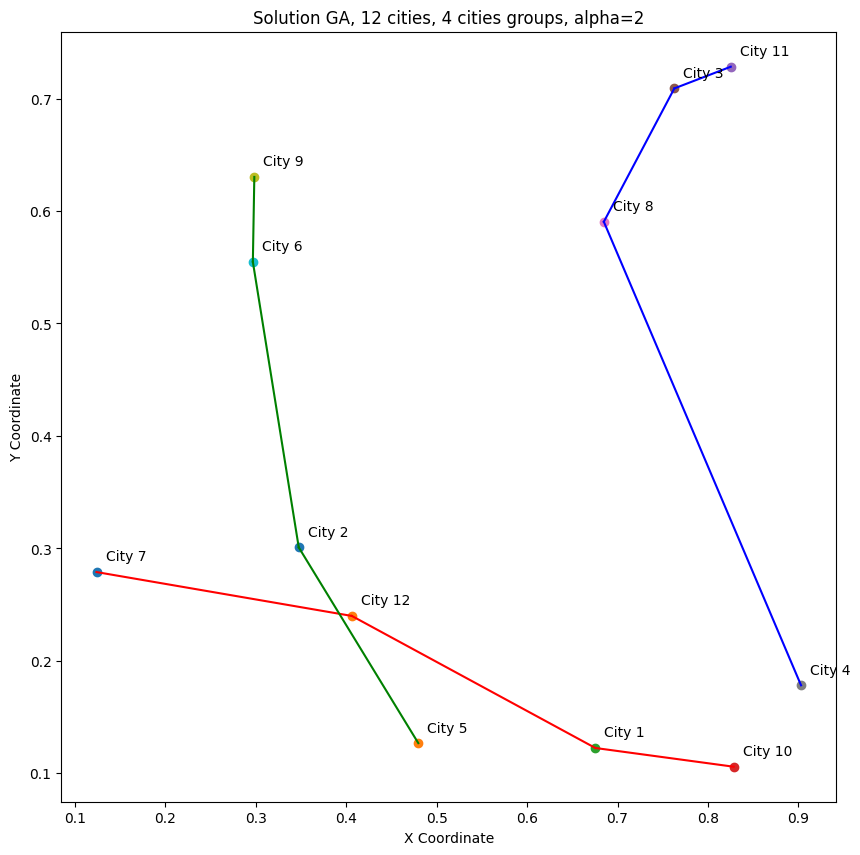

In [ ]:
#solutions=a

number_of_cities_cap=4
groups = [solutions[1][i:i+number_of_cities_cap] for i in range(0, N, number_of_cities_cap)]

#print(groups[0][0])
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green']

# Plot the cities
for coord in solutions[1]:
    plt.scatter(coord[0][0],coord[0][1])
    plt.annotate(f'City {coord[1]+1}', (coord[0][0]+.01, coord[0][1]+.01))

# Connect cities in the same group
for group, color in zip(groups, colors):
    for i in range(3):  # Connect each city to the next city in the group
        plt.plot([group[i][0][0], group[i+1][0][0]],
                [group[i][0][1], group[i+1][0][1]], color=color)

plt.title(f'Solution GA, 12 cities, 4 cities groups, alpha={alpha}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

###GA Implementation of the problem??

In [ ]:
# This is our list of numbers
numbers = [10, 25, 40, 1, 56]

# Our target number
target = 20

# Our fitness function which calculates the distance from the target
def distance_from_target(number, target):
    return abs(number - target)

# Using sorted with a lambda function
sorted_numbers = sorted(numbers, key=lambda num: distance_from_target(num, target))

print([distance_from_target(num,target) for num in numbers])
print(numbers)
print()
print(sorted_numbers)

[10, 5, 20, 19, 36]
[10, 25, 40, 1, 56]

[25, 10, 1, 40, 56]


In [ ]:
import numpy as np
#np.random.seed(6)
r=np.random.randint(0,200,size=7)
r[0]
r[1]
print(r)
print()
r=list(r)
r.pop()
print("after pop")
print(r)
print(np.random.choice(3))

selection_point = random.uniform(0,-21)
print(selection_point)

[167 111  23 156 194 108  67]

after pop
[167, 111, 23, 156, 194, 108]
1
-15.467853906856725


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Solutions.py to Solutions.py


In [ ]:
#Example:
#from test import sum_pair
#import test
#print(sum_pair(1,2))
#
#from Solutions import Cities,Optimal_CBC,Heurist_SimAnn
#from Solutions import Plots_TSP,generate_coordinates,compute_distance_matrix,compute_cosII,Opt_TSPV_CBC,Heurist_SimAnn_NP,Heurist_GA_NP
import Solutions
N=50
City_obj=Cities(N)
coords=City_obj.gen_coords_SAI(N, seed=42)
dist_m=City_obj.dist_mat_SAI(coords)
cosines=City_obj.cos_SAI(coords)



In [ ]:
class Plots_MTSP:

  @staticmethod
  def plot_sln_OPT(a_num_cities,a_num_vend,a_coords):
    plt.figure(figsize=(10, 10))
    ciudades=range(0, a_num_cities+1)
    vendedores=range(1, a_num_vend+1)

    for i in ciudades:
      for j in ciudades:
        if i != j and (i!=0 and j!=0):
            for k in vendedores:
                if pulp.value(x[i][j][k]) == 1:

                    plt.plot([a_coords[i-1][0], a_coords[j-1][0]], [a_coords[i-1][1], a_coords[j-1][1]], color='b')

    for i in ciudades:

      if i != 0:
        plt.scatter(a_coords[i-1][0], a_coords[i-1][1], s=100)
        plt.text(a_coords[i-1][0]+0.02, a_coords[i-1][1], f'Ciudad {i}', fontsize=12)

    plt.title(f'Solution CBC, {a_num_cities} cities(sites)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

  @staticmethod
  def plot_sln_MH(a_capacity,a_coords,a_num_cities,a_MH='SA'):

    groups = [a_coords[i:i+a_capacity] for i in range(0, a_num_cities, a_capacity)]
    #print(groups[0])
    plt.figure(figsize=(10, 10))
    # Plot the cities
    for coord in a_coords:
      plt.scatter(coord[0][0],coord[0][1])
      plt.annotate(f'City {coord[1]+1}', (coord[0][0]+.02, coord[0][1]+.02))

    # Connect cities in the same group
    for group in groups:
        for i in range(a_capacity-1):  # Connect each city to the next city in the group
            plt.plot([group[i][0][0], group[i+1][0][0]],
                    [group[i][0][1], group[i+1][0][1]], color='g')

    plt.title(f'Solution {a_MH}, {a_num_cities} cities, {a_num_cities//a_capacity} cities groups')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()


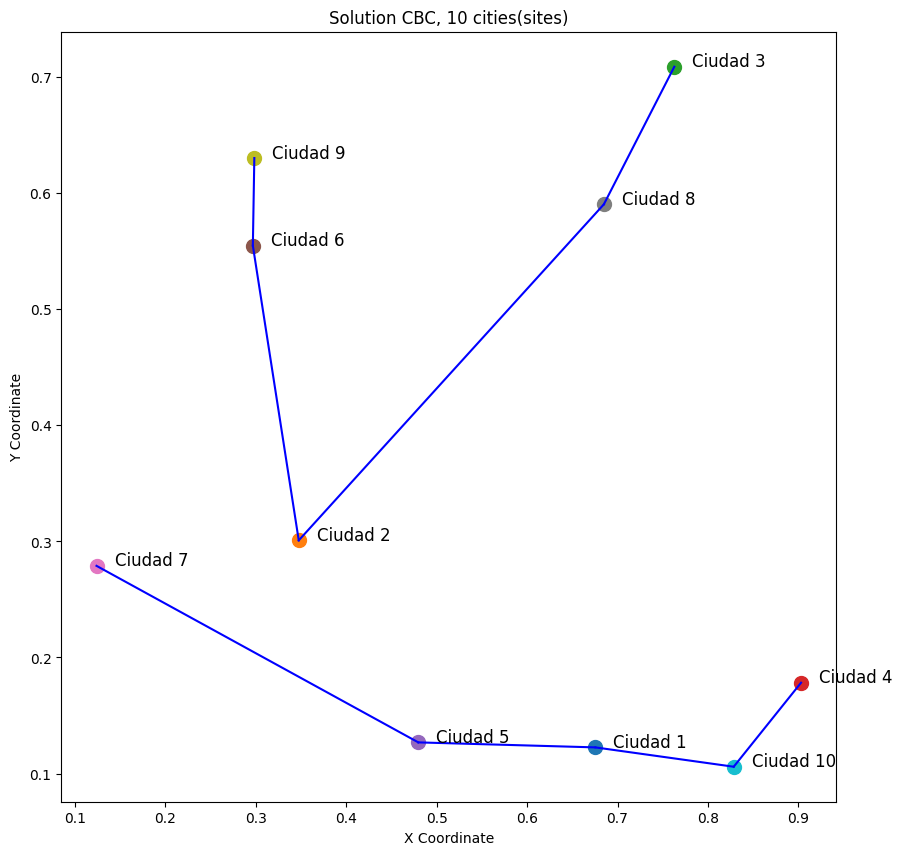

In [ ]:
#print(x)
#print(z)
Plots_MTSP.plot_sln_OPT(10,2,coords)

In [ ]:
import numpy as np
import random
import math

# Generate an initial random solution
def initial_solution(num_cities):
    return list(np.random.permutation(num_cities))

# Generate a neighbor by swapping two cities in the tour
def get_neighbor(solution):
    new_solution = solution.copy()
    i, j = random.sample(range(len(new_solution)), 2)
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

# Objective functions
def distance_objective(solution, distance_matrix):
    return sum(distance_matrix[solution[i-1]][solution[i]] for i in range(len(solution)))

def time_objective(solution, time_matrix):
    return sum(time_matrix[solution[i-1]][solution[i]] for i in range(len(solution)))

# Check Pareto dominance
def dominates(sol1, sol2, distance_matrix, time_matrix):
    d1, t1 = distance_objective(sol1, distance_matrix), time_objective(sol1, time_matrix)
    d2, t2 = distance_objective(sol2, distance_matrix), time_objective(sol2, time_matrix)
    return (d1 <= d2 and t1 <= t2) and (d1 < d2 or t1 < t2)

def simulated_annealing(distance_matrix, time_matrix, T=1000, T_min=1e-3, alpha=0.995, num_iterations=100):
    num_cities = len(distance_matrix)
    current_solution = initial_solution(num_cities)
    pareto_front = [current_solution]

    while T > T_min:
        for _ in range(num_iterations):
            neighbor = get_neighbor(current_solution)
            if dominates(neighbor, current_solution, distance_matrix, time_matrix):
                current_solution = neighbor
                # Update Pareto front
                pareto_front = [sol for sol in pareto_front if not dominates(neighbor, sol, distance_matrix, time_matrix)]
                pareto_front.append(neighbor)
            elif not any(dominates(sol, neighbor, distance_matrix, time_matrix) for sol in pareto_front):
                pareto_front.append(neighbor)
            else:
                diff_objective = (distance_objective(neighbor, distance_matrix) - distance_objective(current_solution, distance_matrix))
                P = math.exp(-diff_objective / T)
                if random.random() < P:
                    current_solution = neighbor
        T *= alpha

    return pareto_front

# Example
N = 20
distance_matrix = np.random.rand(N, N) * 100
time_matrix = np.random.rand(N, N) * 50
pareto_solutions = simulated_annealing(distance_matrix, time_matrix)

# Print Pareto front
for sol in pareto_solutions:
    print(sol, distance_objective(sol, distance_matrix), time_objective(sol, time_matrix))


[3, 9, 10, 17, 7, 15, 5, 19, 2, 11, 14, 12, 0, 1, 6, 4, 13, 16, 18, 8] 914.3362281230889 270.6168879836822
[8, 13, 4, 0, 18, 7, 15, 5, 11, 17, 14, 3, 19, 9, 2, 16, 6, 1, 12, 10] 607.7747816868277 359.5829710793116
[6, 17, 2, 16, 3, 19, 5, 13, 4, 12, 10, 0, 8, 9, 18, 7, 15, 11, 14, 1] 644.2599558265557 333.40679163199377
[8, 3, 12, 16, 19, 0, 5, 13, 6, 4, 10, 7, 17, 15, 1, 9, 18, 2, 14, 11] 976.9485341102651 291.885987554807
[7, 6, 13, 2, 15, 11, 4, 10, 17, 18, 5, 9, 14, 12, 1, 8, 3, 16, 0, 19] 1002.9764535537668 291.75616516812556
[7, 6, 13, 2, 15, 4, 12, 10, 17, 18, 5, 9, 14, 11, 1, 8, 3, 16, 0, 19] 990.3399918354713 252.87998350212723
[19, 9, 14, 11, 13, 16, 17, 7, 15, 18, 5, 12, 10, 0, 4, 1, 6, 8, 3, 2] 838.766610060828 304.5821977054266
[6, 14, 9, 2, 10, 3, 11, 12, 16, 13, 7, 17, 19, 0, 5, 4, 18, 8, 15, 1] 876.7864070147775 305.3072784755017
[9, 18, 2, 10, 17, 19, 1, 12, 0, 5, 4, 14, 6, 7, 3, 11, 15, 16, 13, 8] 964.7418181094292 310.6124397523393
[18, 8, 12, 19, 2, 0, 1, 7, 9, 14, 

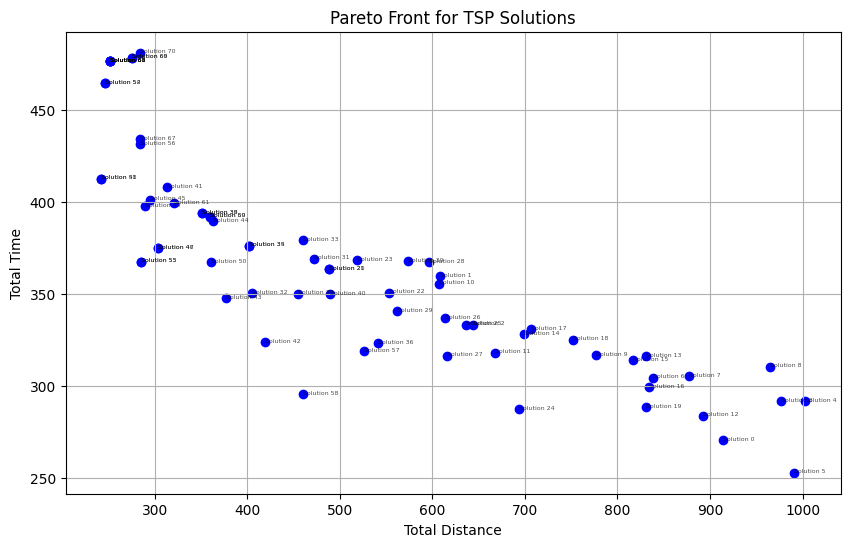

In [ ]:
import matplotlib.pyplot as plt

def visualize_pareto_front(pareto_solutions, distance_matrix, time_matrix):
    """
    Visualize the Pareto front for multi-objective TSP solutions.

    :param pareto_solutions: List of solutions that form the Pareto front.
    :param distance_matrix: Matrix containing pairwise distances between cities.
    :param time_matrix: Matrix containing pairwise times between cities.
    """
    distances = [distance_objective(sol, distance_matrix) for sol in pareto_solutions]
    times = [time_objective(sol, time_matrix) for sol in pareto_solutions]

    plt.figure(figsize=(10, 6))
    plt.scatter(distances, times, c='blue', marker='o')

    for idx, sol in enumerate(pareto_solutions):
        label = f"Solution {idx}"
        plt.annotate(label, (distances[idx], times[idx]), fontsize=4.5, alpha=0.7)

    plt.title('Pareto Front for TSP Solutions')
    plt.xlabel('Total Distance')
    plt.ylabel('Total Time')
    plt.grid(True)
    plt.show()

# Example usage:
visualize_pareto_front(pareto_solutions, distance_matrix, time_matrix)

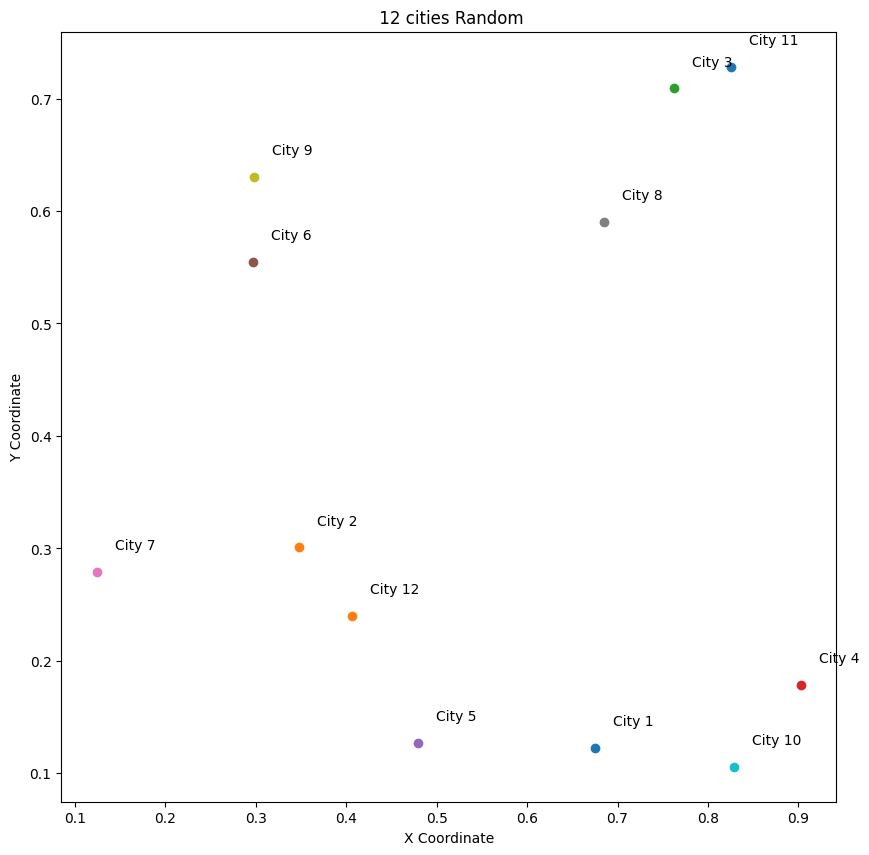

In [ ]:
N=12
City_obj=Cities(N)
coords=City_obj.gen_coords_SAI(N, seed=42)
#dist_m=City_obj.dist_mat_SAI(coords)
#osines=City_obj.cos_SAI(coords)
# Form 3 groups of 4 cities each
number_of_cities_cap=4
groups = [coords[i:i+number_of_cities_cap] for i in range(0, N, number_of_cities_cap)]

#print(groups[0][0])
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green']

# Plot the cities
for coord in coords:
    plt.scatter(coord[0][0],coord[0][1])
    plt.annotate(f'City {coord[1]+1}', (coord[0][0]+.02, coord[0][1]+.02))

# Connect cities in the same group
#for group, color in zip(groups, colors):
 #   for i in range(3):  # Connect each city to the next city in the group
  #      plt.plot([group[i][0][0], group[i+1][0][0]],
   #             [group[i][0][1], group[i+1][0][1]], color='green')

plt.title(f' 12 cities Random')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()